In [183]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib as mpl

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from itertools import product

from tqdm import tqdm

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Идеи для фич

1) лаги/средние/...
2) курс доллара
3) дата налогового дня?
4) праздники
5) время отдыха
6) ...

# Загрузка данных

In [204]:
df = pd.read_excel("/home/owner/Documents/DEV/Time_series/Project 1_2024.xlsx", parse_dates=['Date'], index_col='Date', usecols=['Balance', 'Date'])

In [205]:
df

Balance
Date                
2017-01-09 -0.155904
2017-01-10 -0.125572
2017-01-11  0.007767
2017-01-12  0.800391
2017-01-13 -0.019721
...              ...
2021-03-27  0.000000
2021-03-28  0.000000
2021-03-29 -1.017679
2021-03-30 -0.259687
2021-03-31 -0.004878

[1543 rows x 1 columns]

# График временного ряда

<Axes: xlabel='Date', ylabel='Balance'>

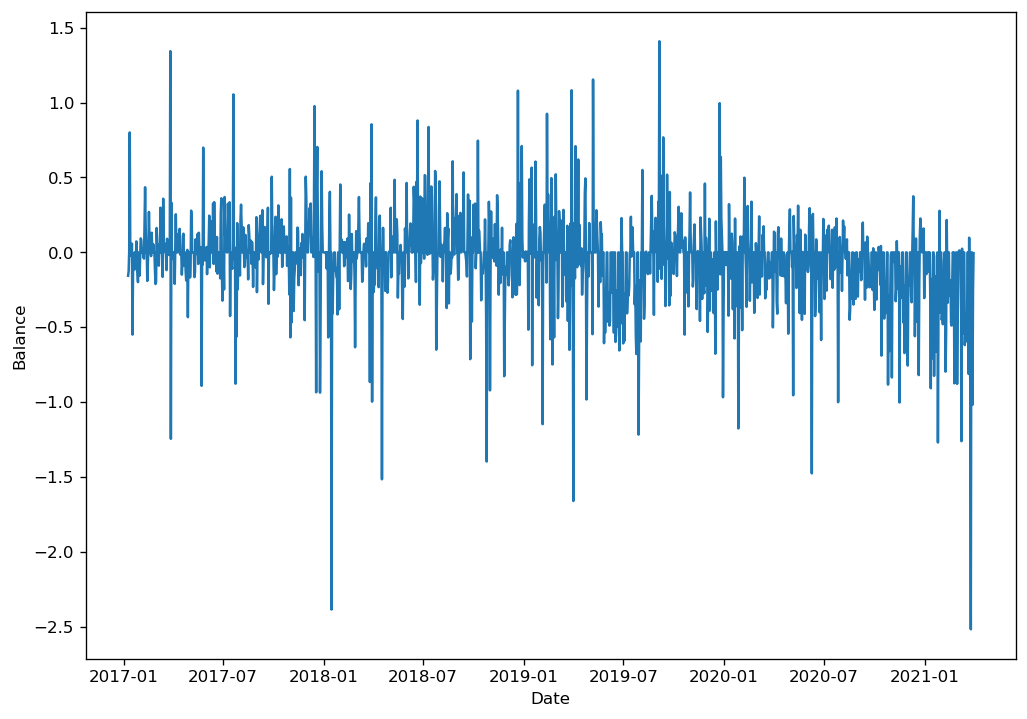

In [29]:
sns.lineplot(x = df.index, y = df.Balance)

# Тест Дики-Фуллера для проверки на стационарность

In [30]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [31]:
adf_test(df.Balance)

Results of Dickey-Fuller Test:
Test Statistic                   -4.114101
p-value                           0.000918
#Lags Used                       20.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
dtype: float64


In [32]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [33]:
check_stationarity(df.Balance)

ADF Statistic: -4.114101
p-value: 0.000918
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


# Избавляемся от выбросов

<Axes: xlabel='Date', ylabel='Balance'>

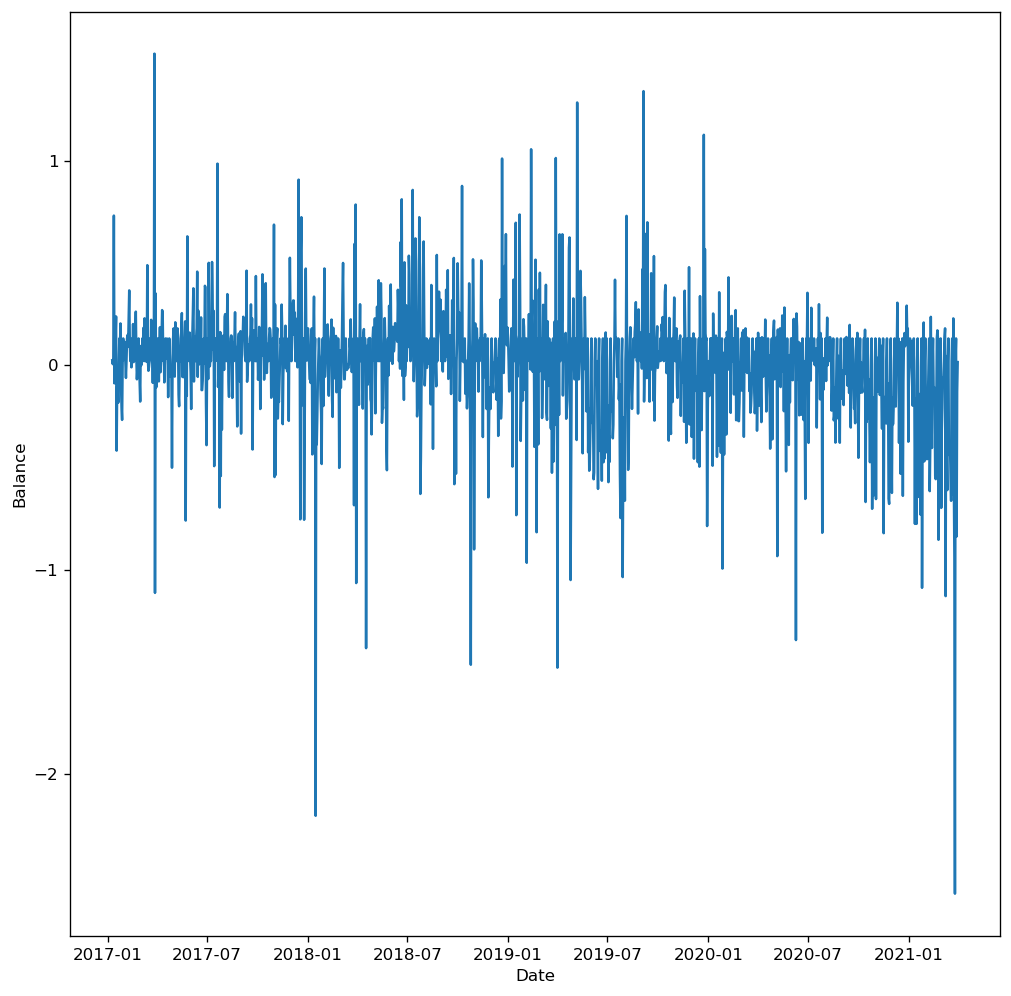

In [365]:
sns.lineplot(x = df.index, y = df.Balance)

In [368]:
def zscore(s, window, thresh=3, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

df['Balance_balanced'] = zscore(df['Balance'], window=50)

<Axes: xlabel='Date', ylabel='Balance'>

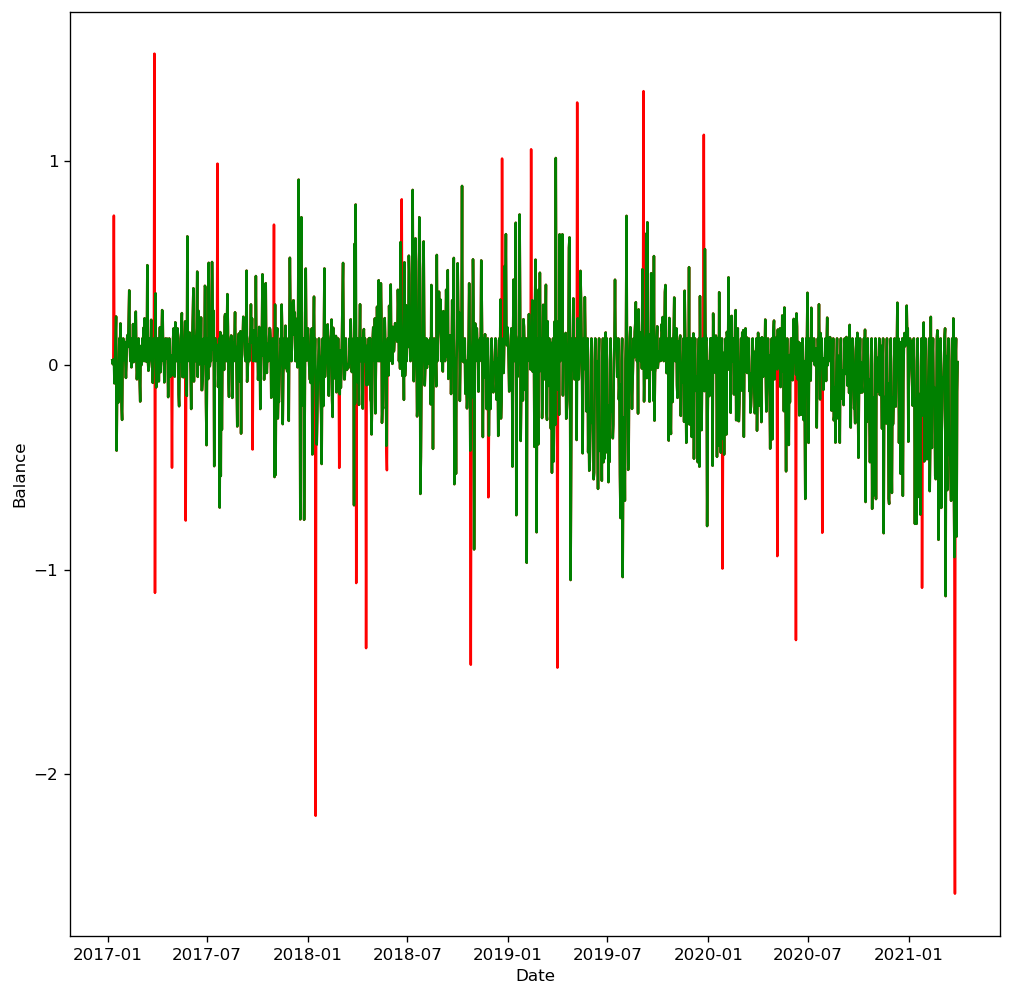

In [373]:
sns.lineplot(df.Balance, color='red')
sns.lineplot(df.Balance_balanced, color='green')

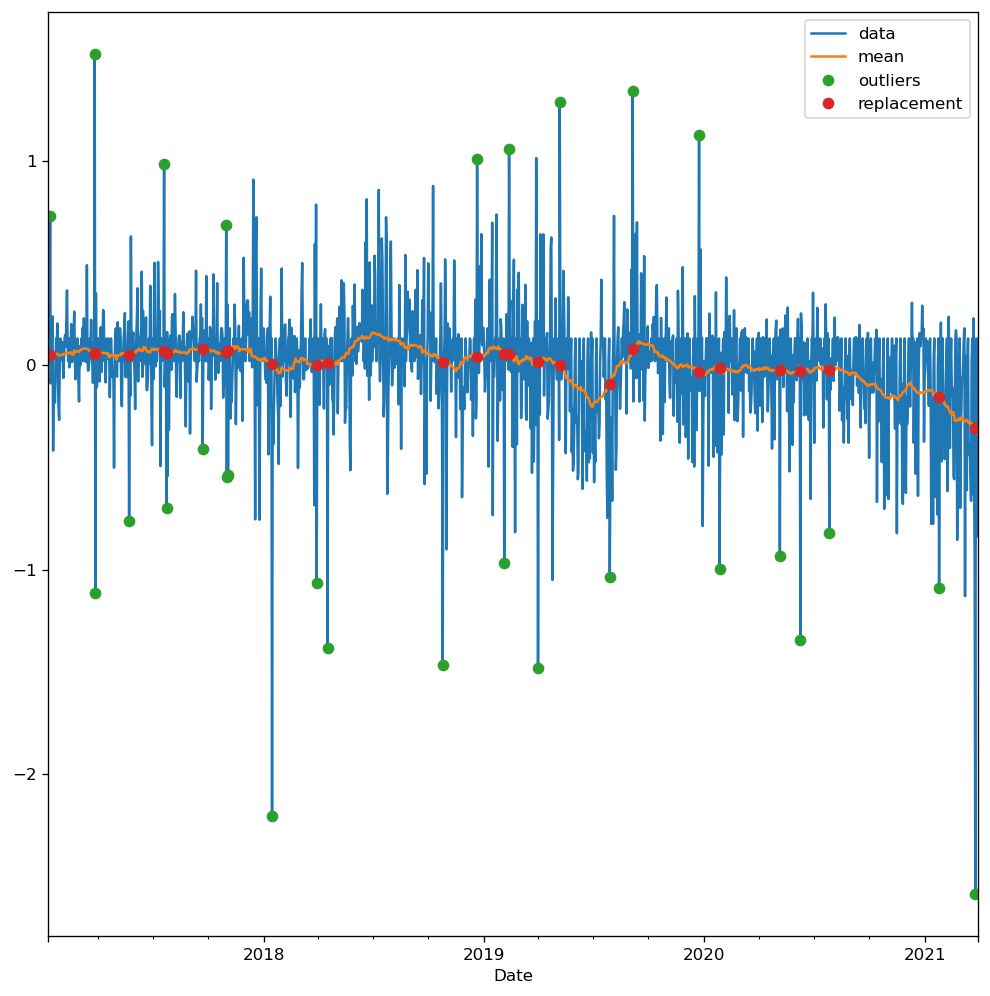

In [369]:
z, avg, std, m = zscore(df.Balance, window=70, return_all=True)

ax = plt.subplot()

df.Balance.plot(label='data')
avg.plot(label='mean')
df.loc[~m, 'Balance'].plot(label='outliers', marker='o', ls='')
avg[~m].plot(label='replacement', marker='o', ls='')
plt.legend()

Замену можно провести, все найс

In [485]:
df.Balance = df.Balance_balanced
df.drop(columns='Balance_balanced')

Balance
Date                
2017-01-09  0.023691
2017-01-10  0.004693
2017-01-11  0.027189
2017-01-12  0.023283
2017-01-13 -0.089188
...              ...
2021-03-27  0.019422
2021-03-28  0.130265
2021-03-29 -0.838085
2021-03-30 -0.129422
2021-03-31  0.014544

[1543 rows x 1 columns]

In [ ]:
sns.lineplot(df.Balance)

https://stackoverflow.com/questions/75938497/outlier-detection-of-time-series-data

# Разложение на компоненты (попытка)

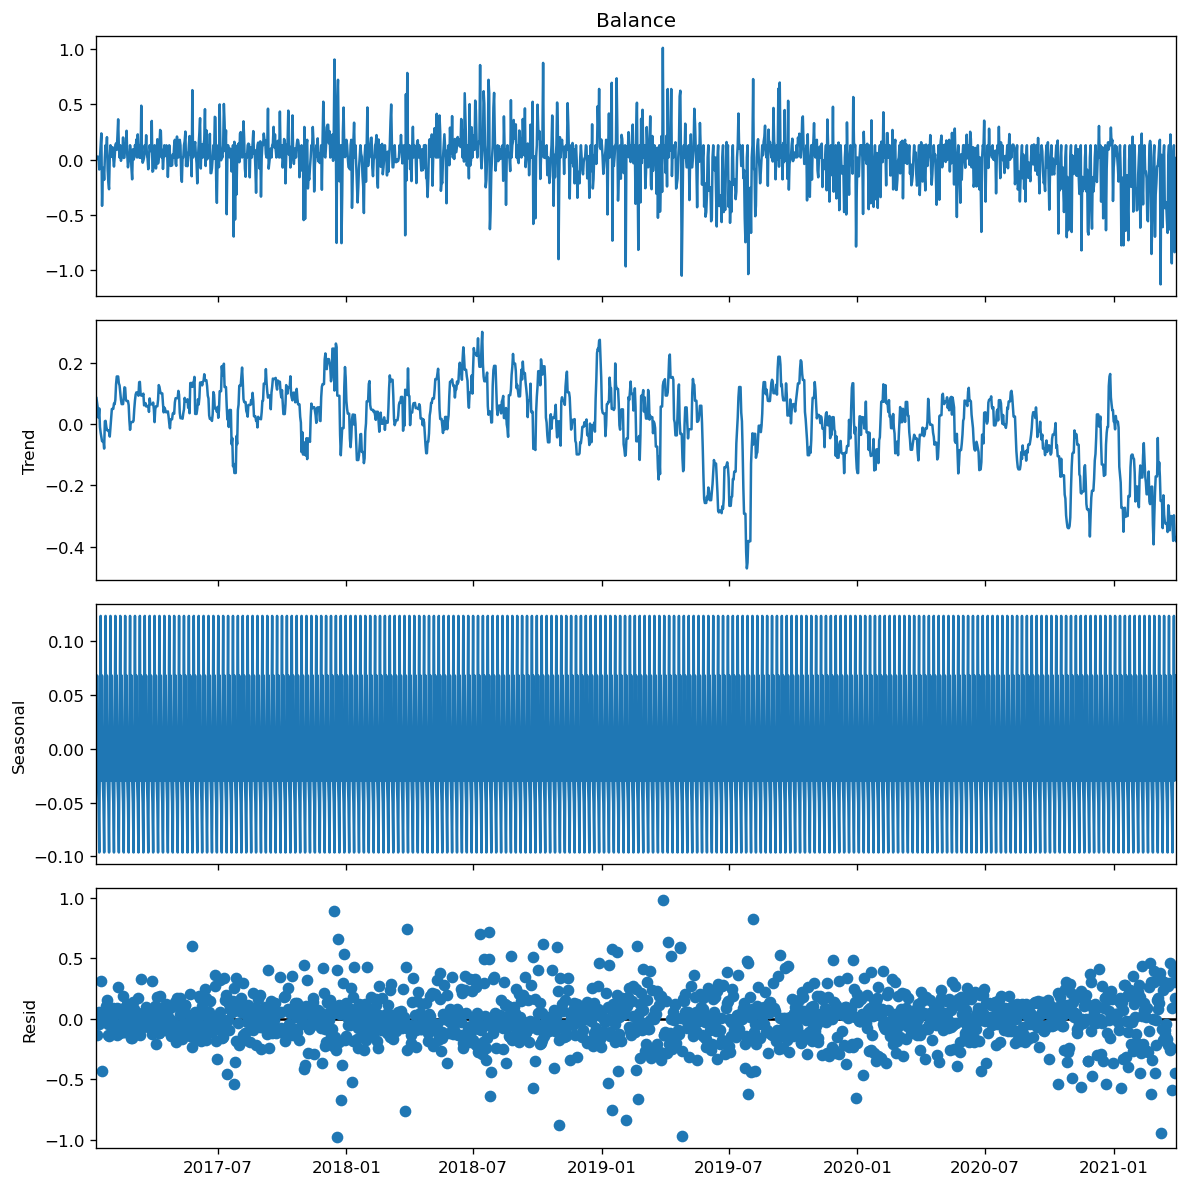

In [375]:
# Additive Decomposition
result_add = seasonal_decompose(df.Balance, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
seasonal = result_add.seasonal
plt.show()

In [376]:
BalanceD1 = (df.Balance - df.Balance.shift(7))[7:]

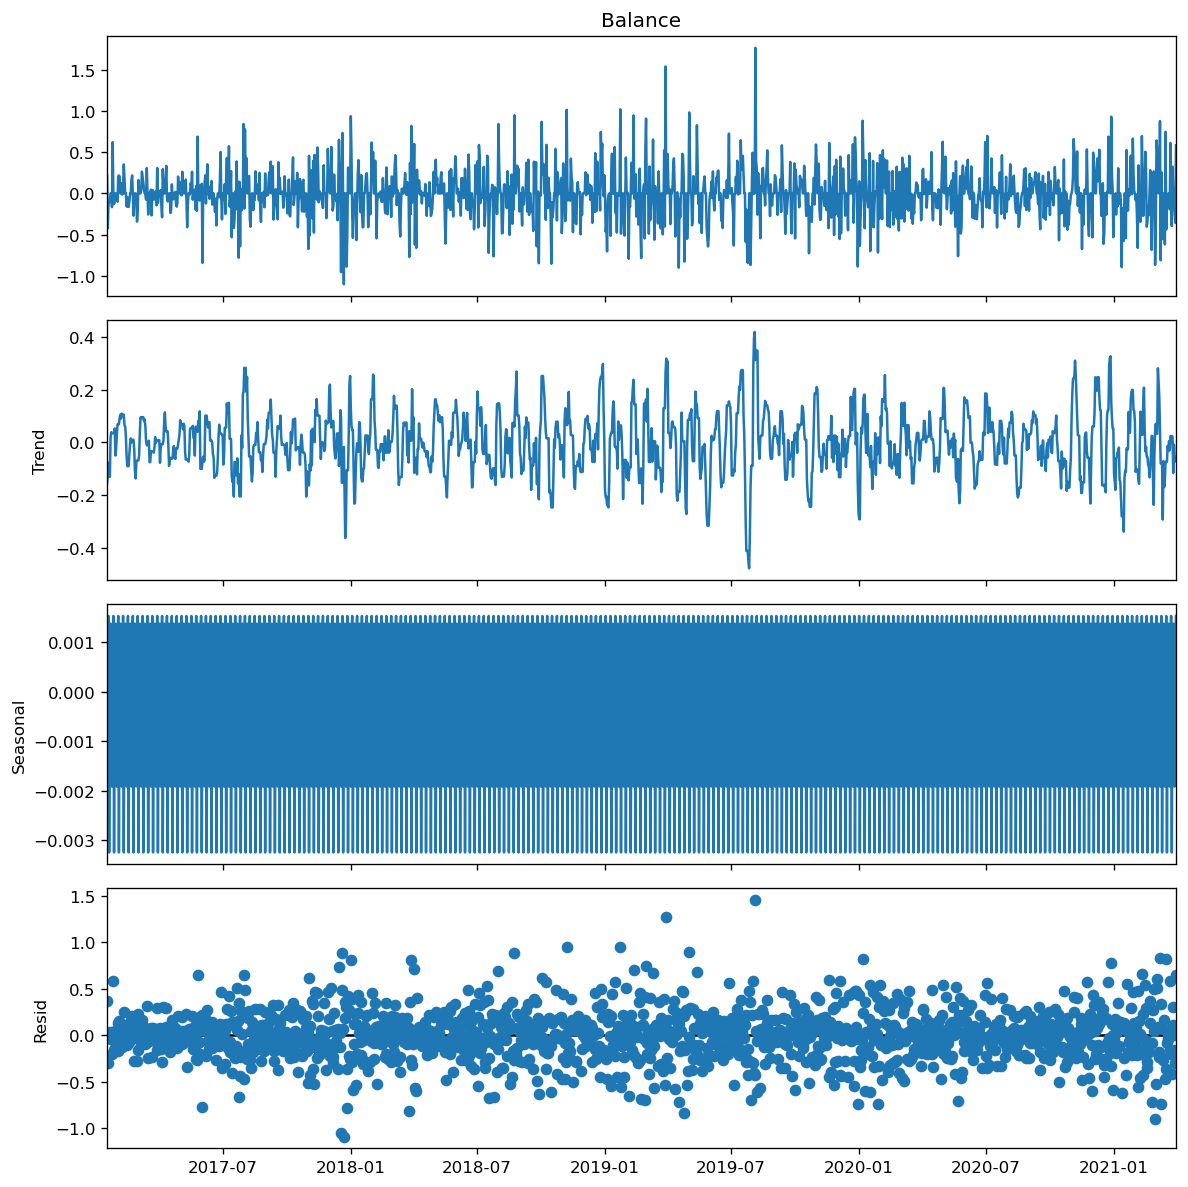

In [377]:
# Additive Decomposition
result_add2 = seasonal_decompose(BalanceD1, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add2.plot()
seasonal2 = result_add2.seasonal
plt.show()

<Axes: xlabel='Date', ylabel='seasonal'>

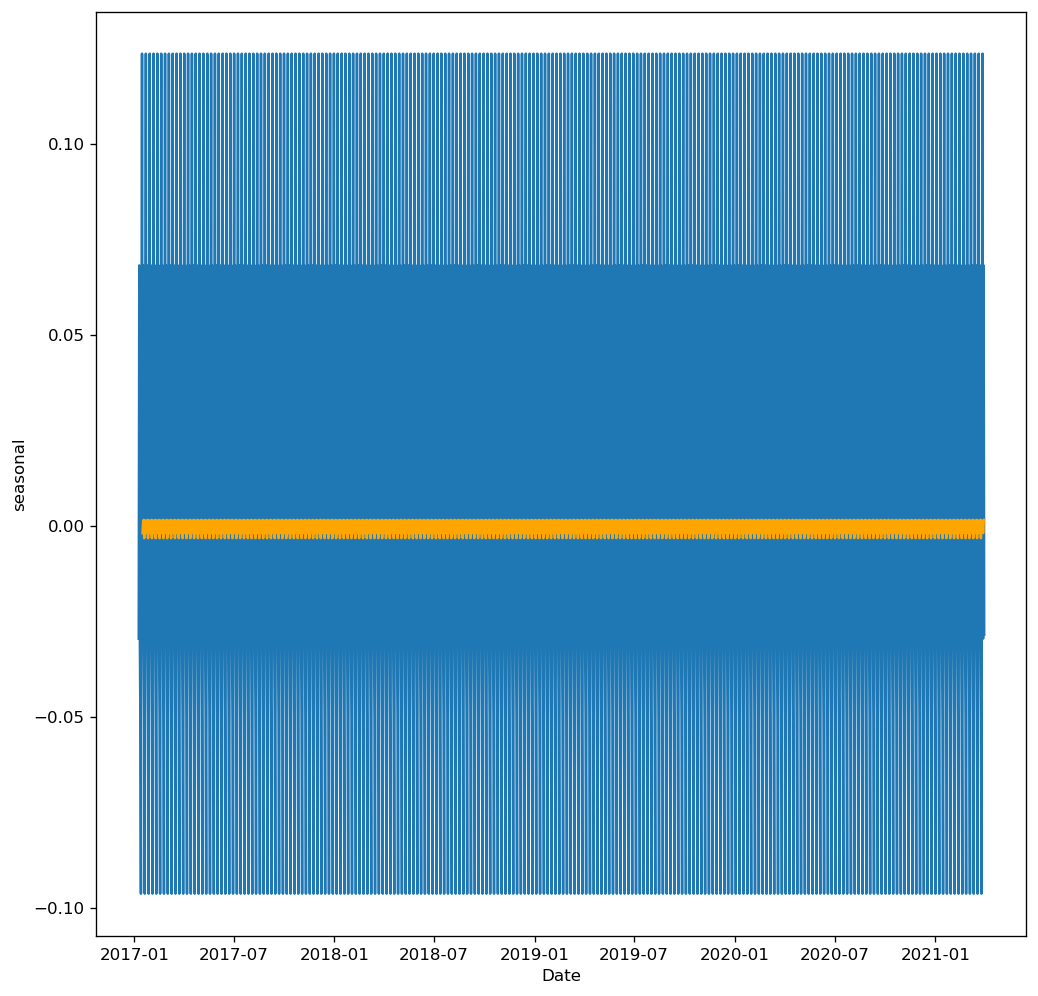

In [378]:
sns.lineplot(seasonal)
sns.lineplot(seasonal2, color='orange')

Сезонная компонента уменьшена

In [379]:
BalanceD2 = (BalanceD1 - BalanceD1.shift(7))[7:]

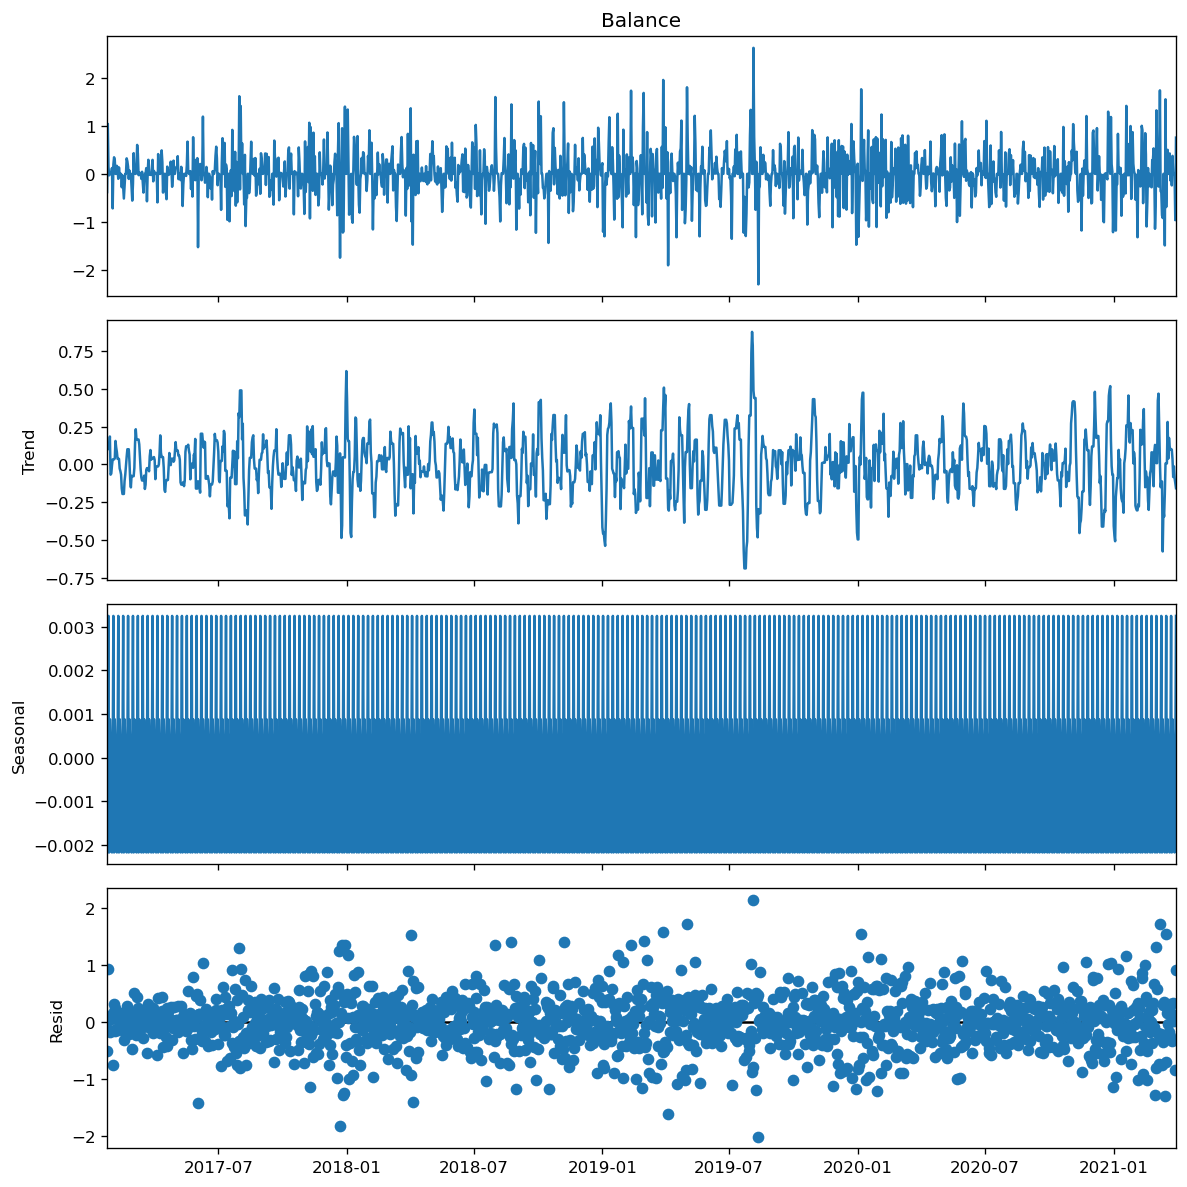

In [380]:
# Additive Decomposition
result_add3 = seasonal_decompose(BalanceD2, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add3.plot()
seasonal3 = result_add2.seasonal
plt.show()

<Axes: xlabel='Date', ylabel='seasonal'>

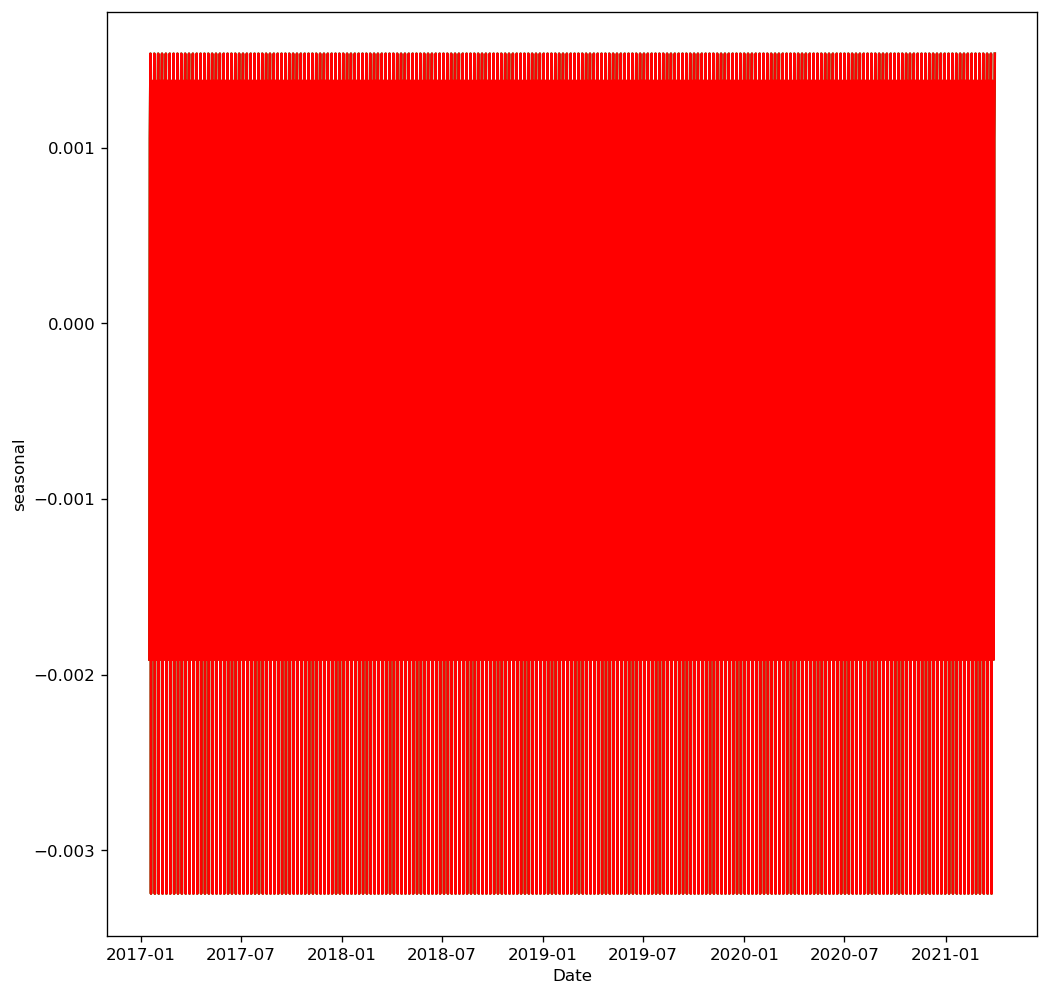

In [382]:
sns.lineplot(seasonal2, color='green')
sns.lineplot(seasonal3, color='red')

Толковых изменений нет

# Стабилизация Дисперсии (?)

# Изучение ACF/PACF

In [383]:
def tsplot(y, lags=None, figsize=(15, 15), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))'
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise


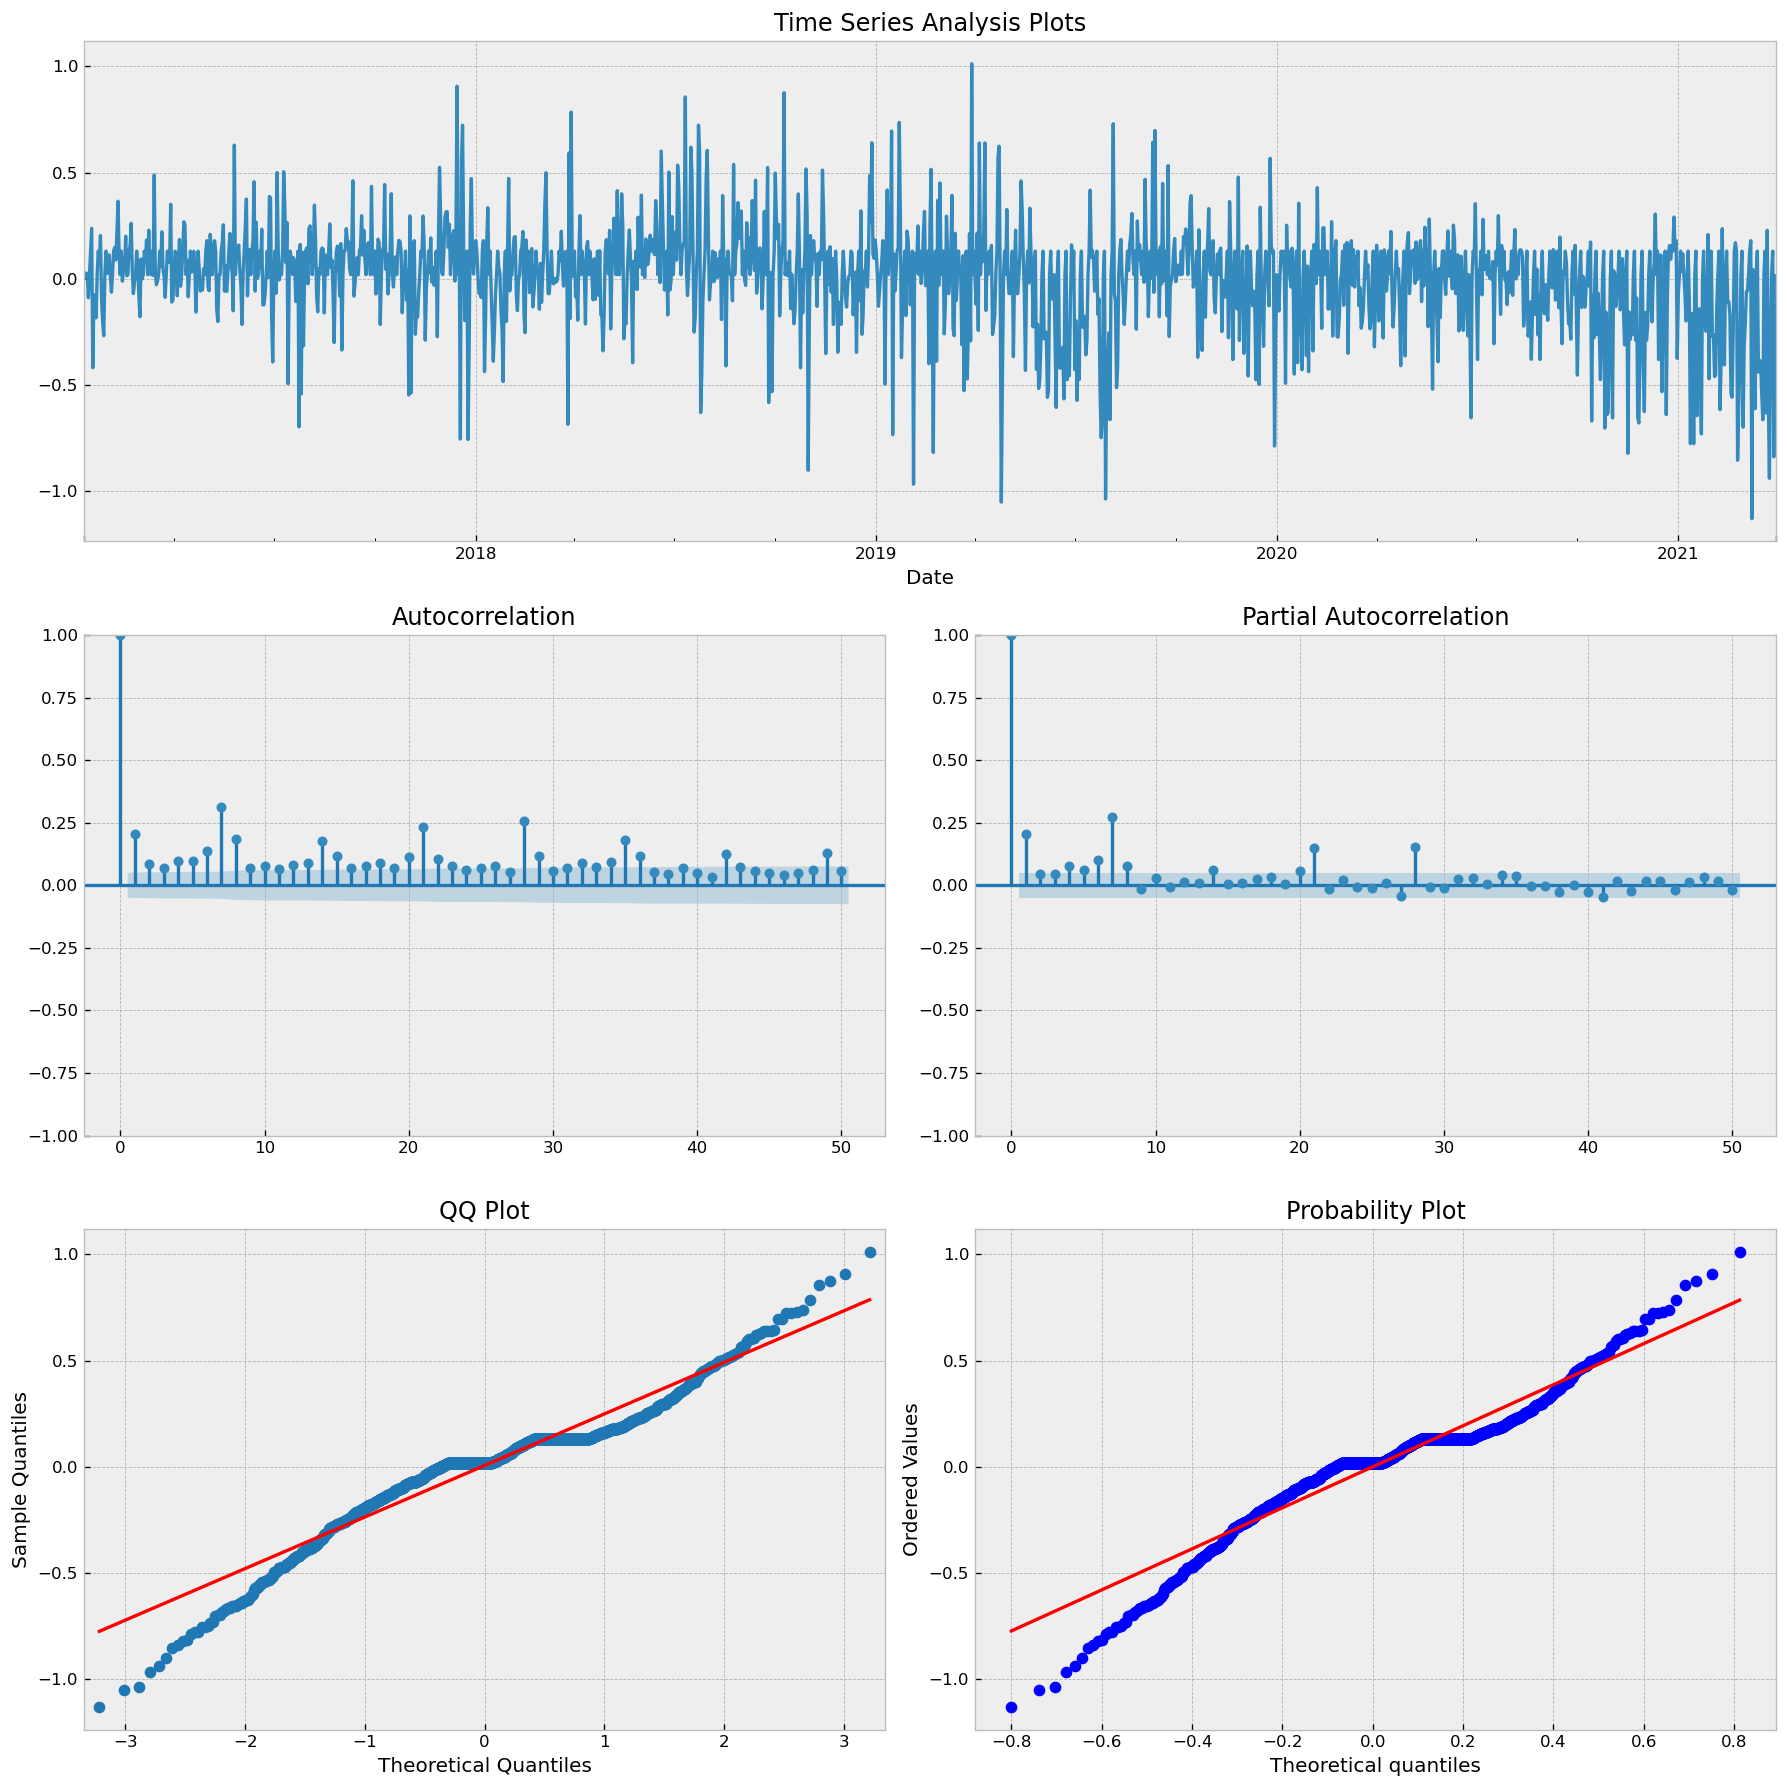

In [385]:
tsplot(df.Balance, lags=50)

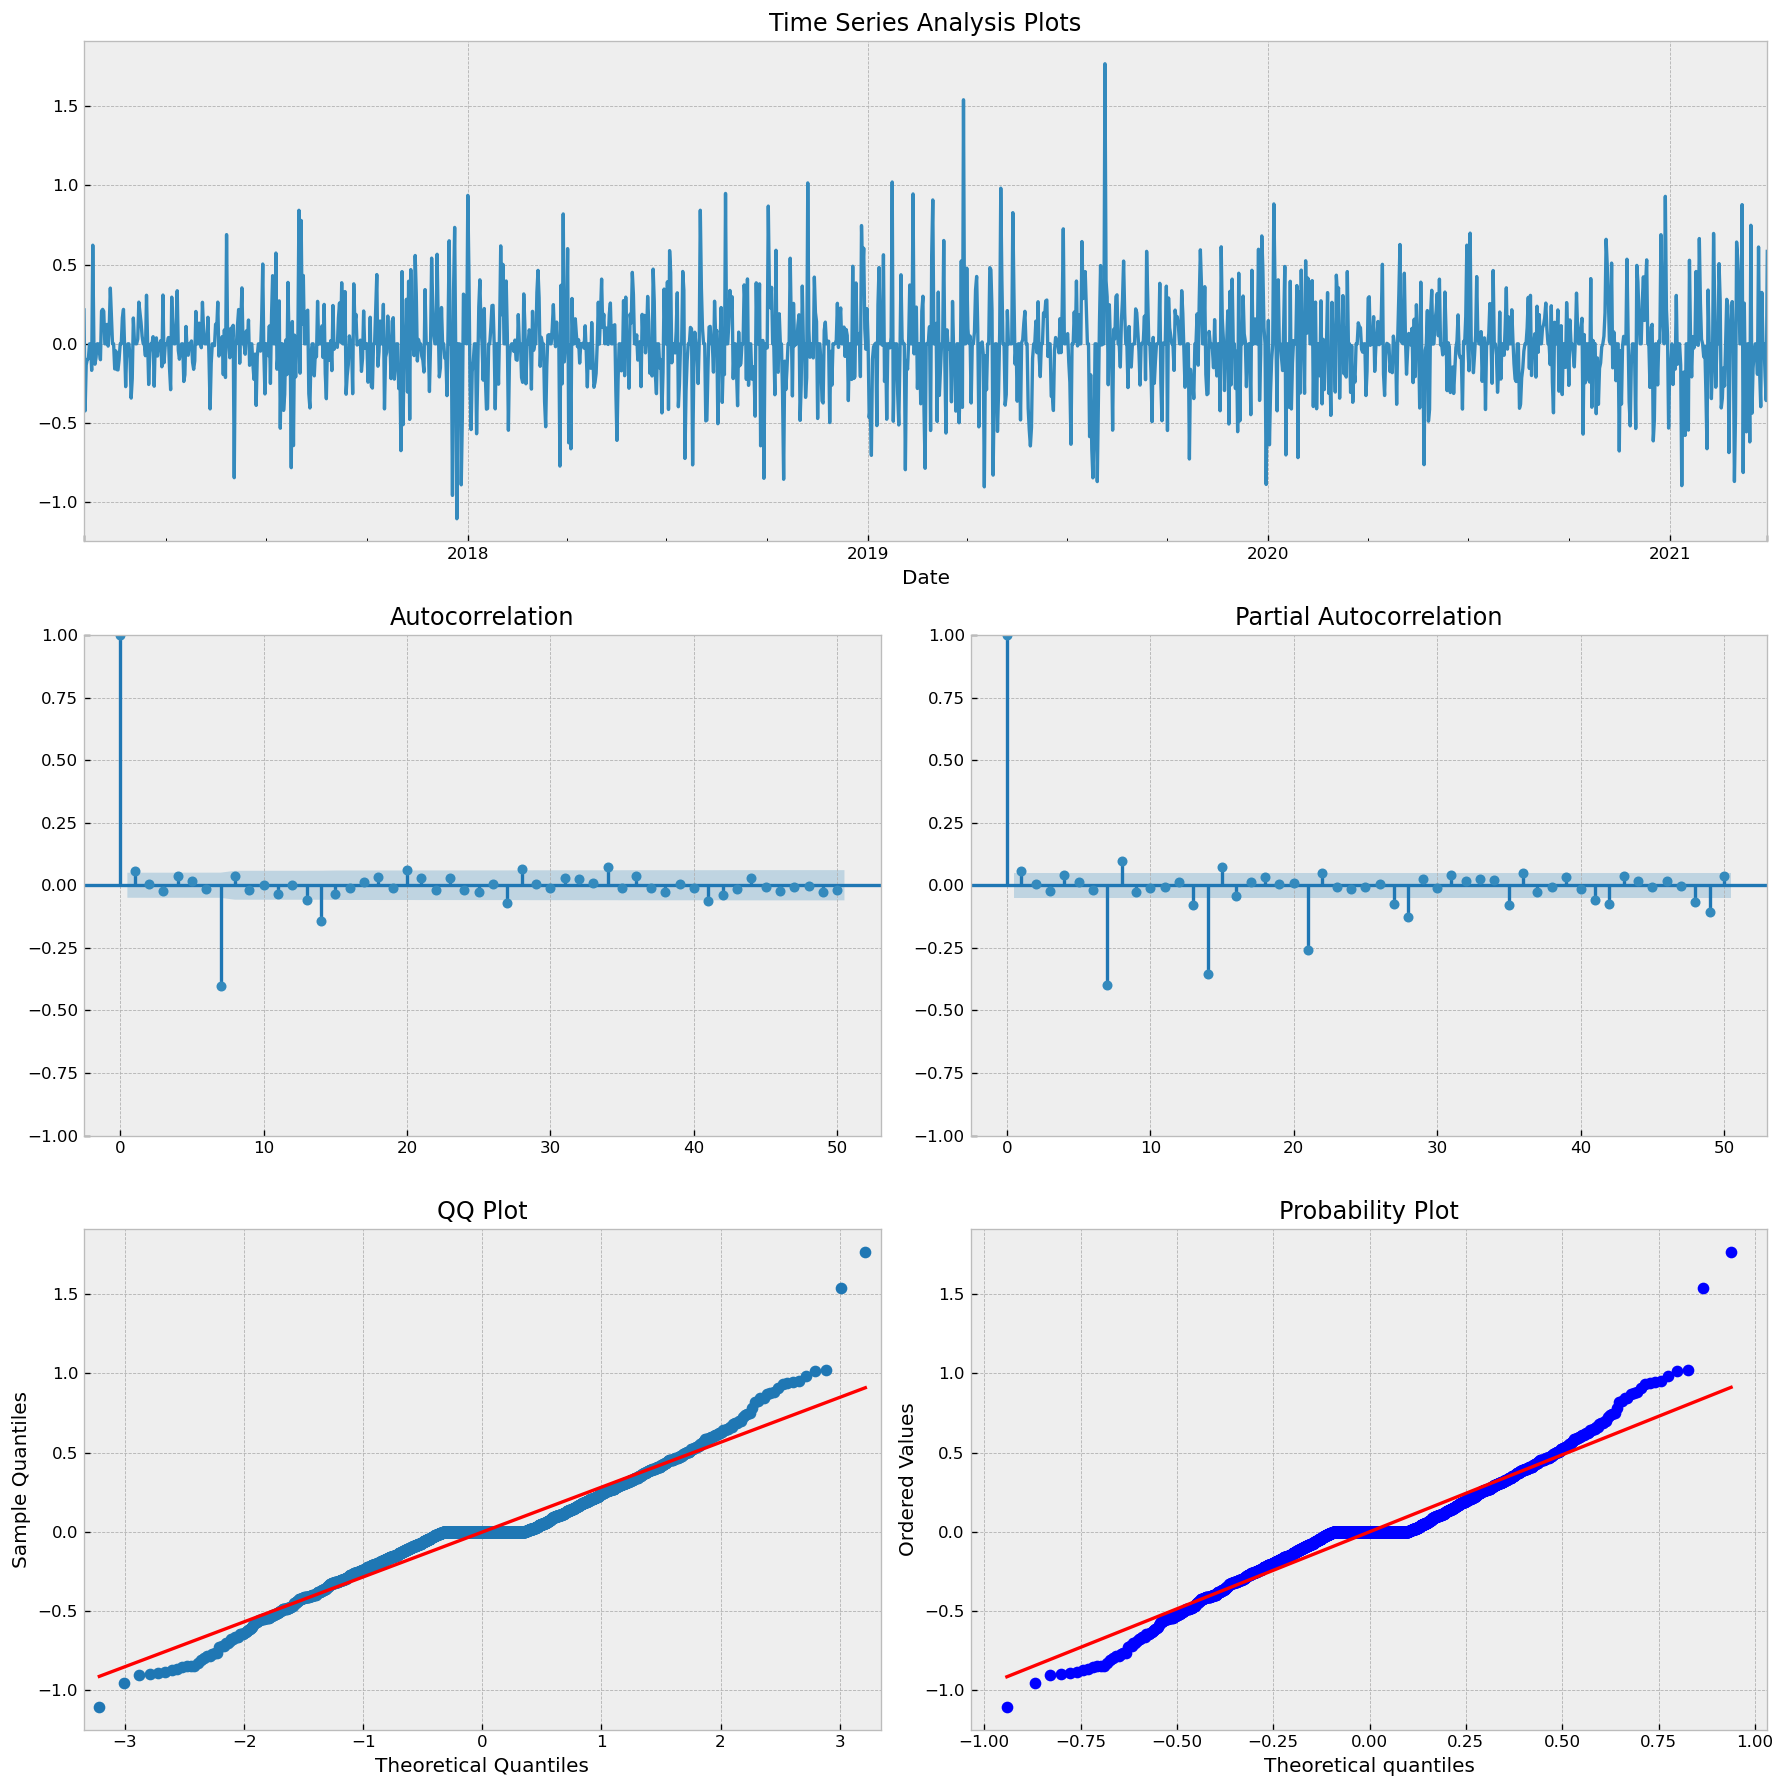

In [386]:
tsplot(BalanceD1, lags=50)

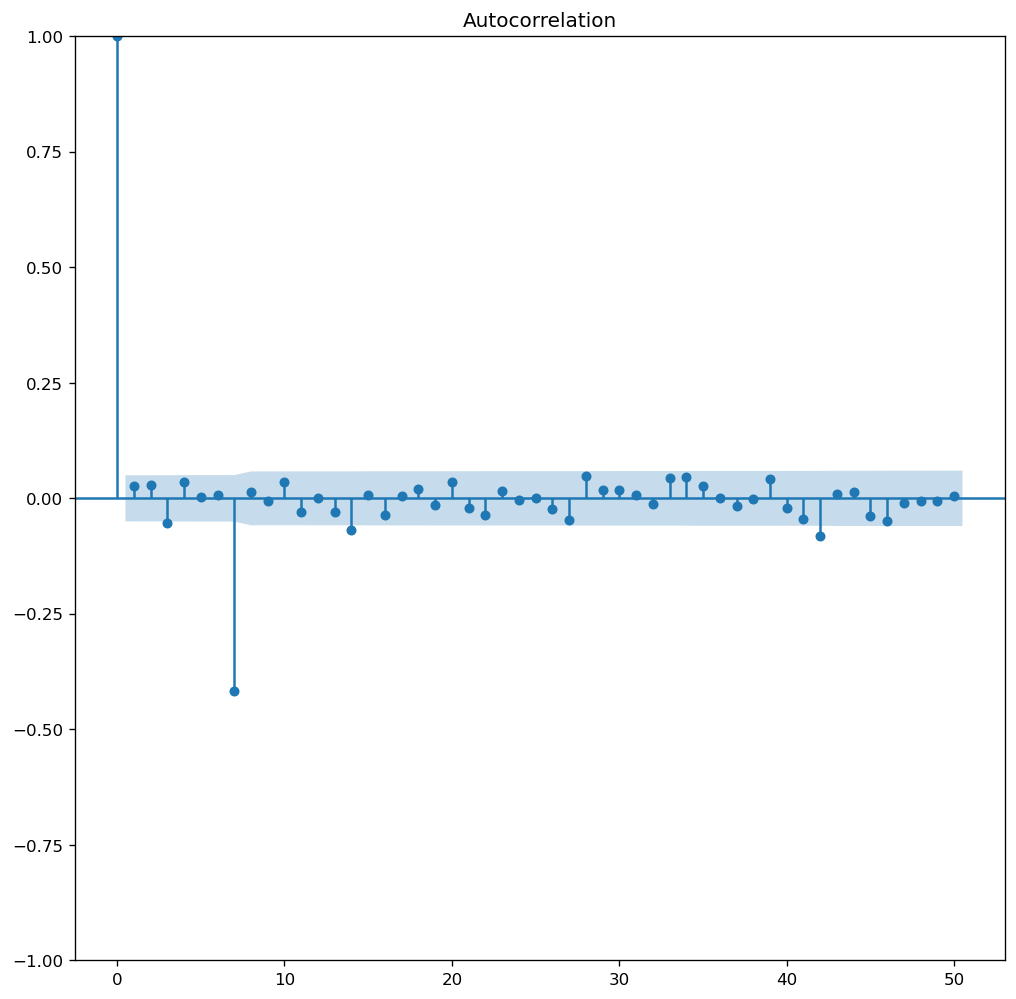

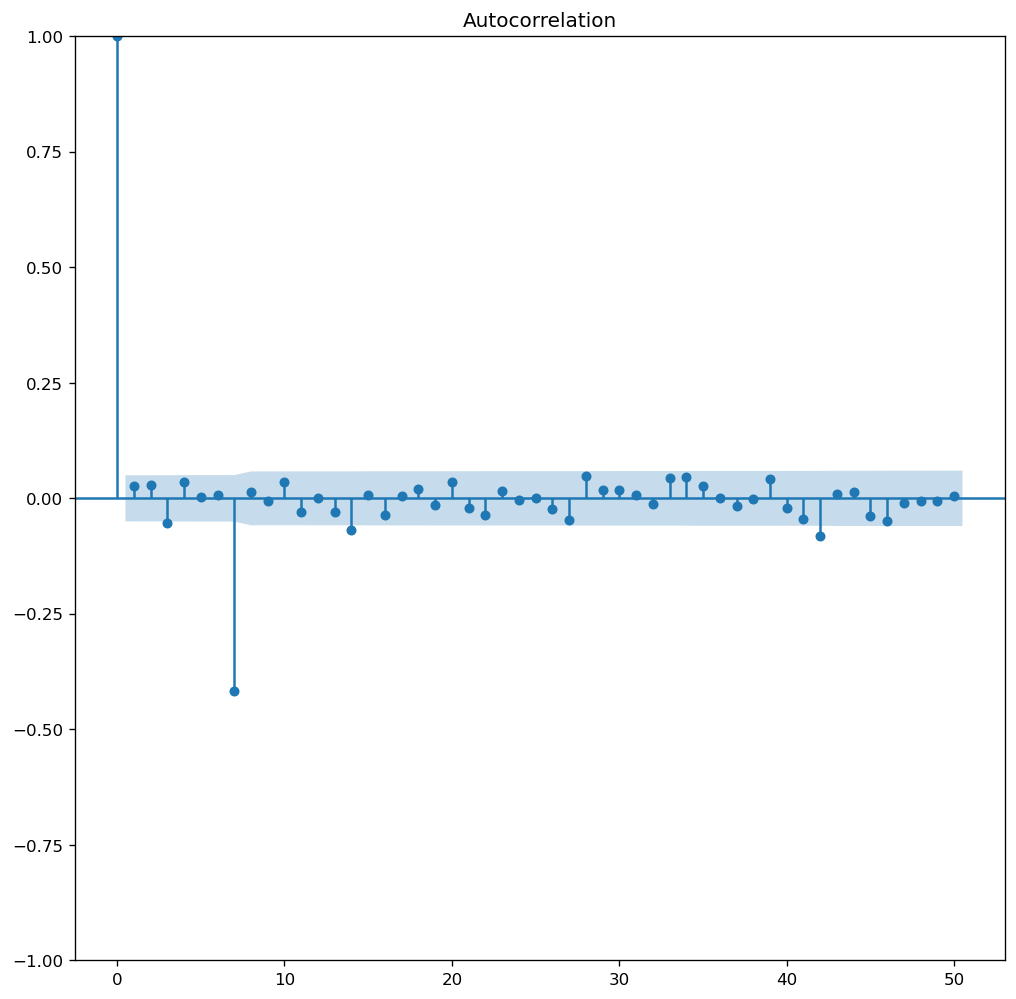

In [348]:
sm.graphics.tsa.plot_acf(BalanceD1, lags=50, alpha=0.05)

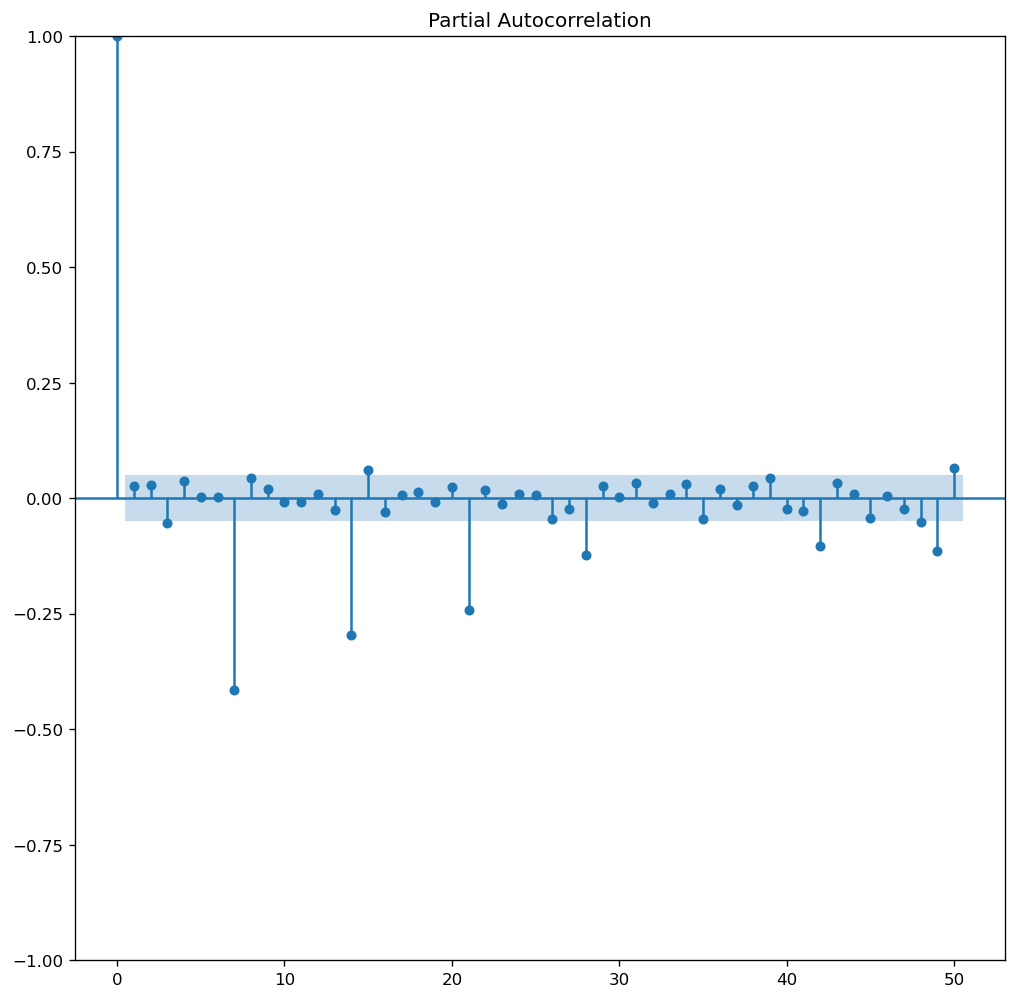

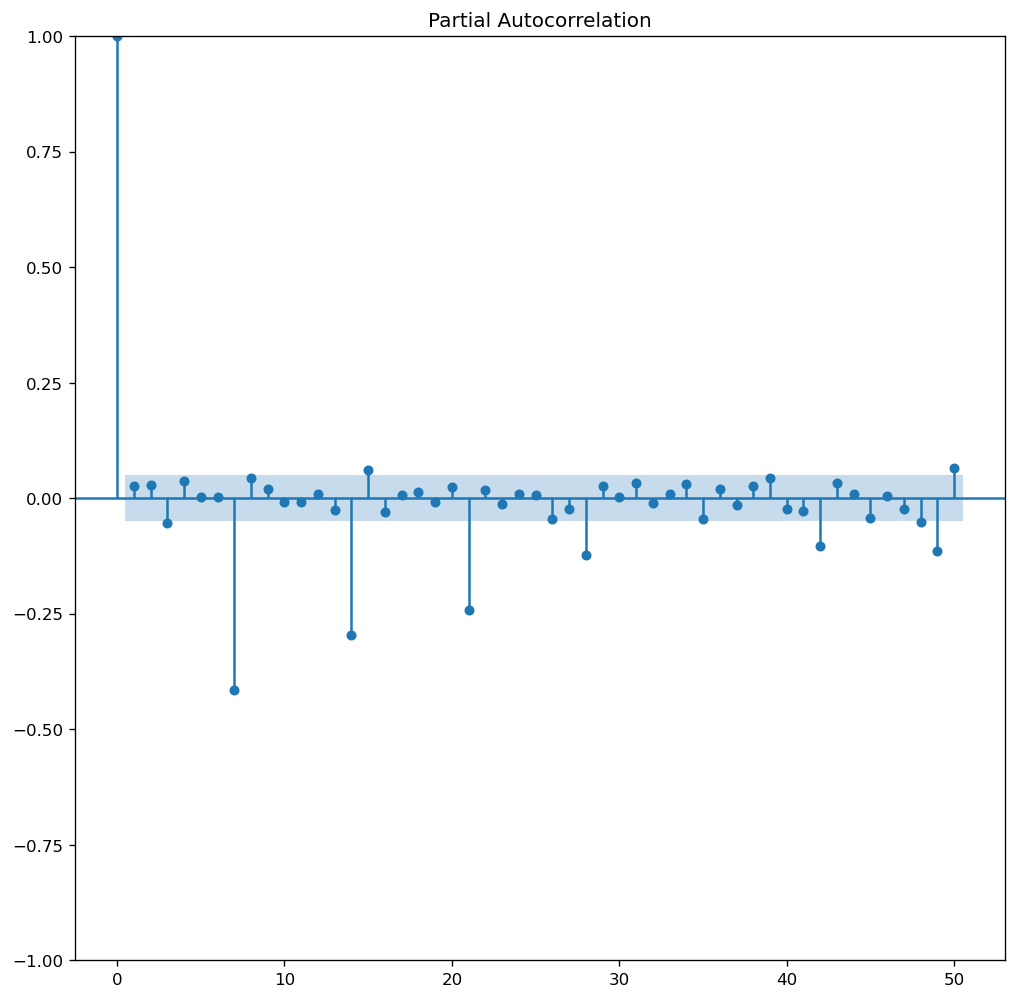

In [347]:
sm.graphics.tsa.plot_pacf(BalanceD1, lags=50, alpha=0.05)

Похоже на SARIMA(p=2, i=0, q=2, P=5, I=0, Q=1, S=7)

# Моделирование

In [387]:
start_date = df.index[0]
threshold_date = np.datetime64('2019-07-30')
end_date = df.index[-1]

In [449]:
import itertools
import math
from sklearn.metrics import r2_score, mean_absolute_error

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 4)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 4)  # Moving average order
P_values = range(0, 5) # Seasonal autoregressive order
D_values = [1]  # Seasonal differencing order
Q_values = range(0, 3)  # Seasonal moving average order
m_values = [7]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))
results = []

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None
best_chosen = None
mask_before = (df.index < threshold_date) & (df.index >= start_date)
mask_after = (df.index >= threshold_date) & (df.index <= end_date)

warnings.filterwarnings('ignore')


# Perform grid search
for params in tqdm(param_combinations):
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model_chosen = ARIMA(endog=df[mask_before].Balance, 
                               order=order, 
                               seasonal_order=seasonal_order)
        model_chosen = model_chosen.fit()
        aic = model_chosen.aic
        
        # Ensure the convergence of the model
        if not math.isinf(model_chosen.zvalues.mean()):
            predict=model_chosen.predict(start=threshold_date, end=end_date, exog=None)
            err_max = (df.Balance[mask_after]-predict).abs().max()
            mae = mean_absolute_error(df.Balance[mask_after], predict)
            llf = model_chosen.llf
            r2 = r2_score(df.Balance[mask_after], predict)
            aic = model_chosen.aic
            if aic < best_aic:
                best_aic = aic
                best_params = params
                best_chosen = model_chosen
                best_err_max = err_max
                best_mae = mae
                best_llf = llf
                best_r2 = r2
                best_combination = params
                best_aic = aic
            results.append(list(params[:-1]) + [err_max, mae, llf, r2, aic])
        else:
            print(order, seasonal_order, 'not converged')
    except ValueError:
        print('wrong parameters:', params)
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

100%|██████████| 240/240 [11:23<00:00,  2.85s/it]

Best Parameters: (3, 0, 3, 3, 1, 1, 7)
Best AIC: -154.98617101789017


In [469]:
result_exog_table = pd.DataFrame(results)
result_exog_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'MAE', 'LLF', 'R2', 'aic']
print("by LLF:")
display(result_exog_table.sort_values(by=['LLF'], ascending=False).head(1))
print("by err_max:")
display(result_exog_table.sort_values(by=['err_max'], ascending=True).head(1))
print("by MAE:")
display(result_exog_table.sort_values(by=['MAE'], ascending=True).head(1))
print("by aic:")
display(result_exog_table.sort_values(by=['aic'], ascending=True).head(1))
print("by R2:")
display(result_exog_table.sort_values(by=['R2'], ascending=False).head(1))

by LLF:


p  d  q  P  D  Q   err_max       MAE        LLF      R2         aic
239  3  0  3  4  1  2  1.234174  0.154661  88.566871  0.0264 -151.133742

by err_max:


p  d  q  P  D  Q   err_max      MAE        LLF        R2        aic
231  3  0  3  2  1  0  1.027836  0.23263  25.258201 -0.542332 -32.516402

by MAE:


p  d  q  P  D  Q   err_max       MAE        LLF        R2         aic
163  2  0  2  4  1  1  1.184193  0.147018  80.818847  0.129527 -141.637695

by aic:


p  d  q  P  D  Q   err_max       MAE        LLF        R2         aic
235  3  0  3  3  1  1  1.209267  0.153131  88.493086  0.079473 -154.986171

by R2:


p  d  q  P  D  Q   err_max       MAE        LLF        R2         aic
221  3  0  2  3  1  2  1.157806  0.148323  81.609377  0.136371 -141.218754

In [451]:
best_chosen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           Balance   No. Observations:                  932
Model:             ARIMA(3, 0, 3)x(3, 1, [1], 7)   Log Likelihood                  88.493
Date:                           Fri, 05 Apr 2024   AIC                           -154.986
Time:                                   01:02:10   BIC                           -101.858
Sample:                               01-09-2017   HQIC                          -134.718
                                    - 07-29-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5096      0.038     13.377      0.000       0.435       0.584
ar.L2         -0.4892      0.033    -14.730      0.000      -0.554      -0.424
ar.L3          0.9083      0.041     22.073      0.000       0.828       0.989
ma.L1         -0.4246      0.045     -9.462      0.000      -0.513      -0.337
ma.L2          0.4829      0.030     15.976      0.000       0.424       0.542
ma.L3         -0.8994      0.046    -19.684      0.000      -0.989      -0.810
ar.S.L7        0.1758      0.032      5.468      0.000       0.113       0.239
ar.S.L14      -0.0720      0.028     -2.592      0.010      -0.126      -0.018
ar.S.L21       0.0600      0.033      1.817      0.069      -0.005       0.125
ma.S.L7       -0.9774      0.018    -55.067      0.000      -1.012      -0.943
sigma2         0.0476      0.001     34.578      0.000       0.045       0.050
===================================================================================
Ljung-Box (L1) (Q):                   2.77   Jarque-Bera (JB):               605.63
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               2.89   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [452]:
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import nsdiffs

# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(df.Balance,
            m=10,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0
D

0

In [470]:
import pmdarima as pm
best_auto = pm.AutoARIMA(
                        # test='adf',
                        # start_p=0, max_p=4,
                        # d=0,
                        # start_q=0, max_q=4,
                        # start_P=0, max_P=5,
                        start_D=0, max_D=2,
                        # start_Q=0, max_Q=5,
                        m=7,
                        seasonal=True,
                        stationary=True,
                        trace=True,
                        suppress_warnings=True,
                        error_action='ignore',
                        stepwise=True
                      ).fit(y=df.Balance[mask_before])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-132.226, Time=1.89 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-43.050, Time=0.16 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-129.064, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-125.837, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-15.153, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=-128.875, Time=1.38 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=-128.037, Time=1.35 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=-137.219, Time=2.36 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=-121.911, Time=1.98 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=-145.470, Time=2.76 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=-144.527, Time=2.74 sec
 ARIMA(1,0,2)(2,0,2)[7] intercept   : AIC=-151.935, Time=2.42 sec
 ARIMA(1,0,2)(1,0,2)[7] intercept   : AIC=-152.984, Time=2.20 sec
 ARIMA(1,0,2)(0,0,2)[7] intercept   : AIC=-121.830, Time=1.57 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept  

In [454]:
best_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  932
Model:             SARIMAX(2, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood                  85.215
Date:                                Fri, 05 Apr 2024   AIC                           -156.430
Time:                                        01:03:08   BIC                           -122.569
Sample:                                    01-09-2017   HQIC                          -143.516
                                         - 07-29-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.657      0.511      -0.001       0.002
ar.L1          0.1501      0.028      5.298      0.000       0.095       0.206
ar.L2          0.0058      0.028      0.205      0.838      -0.050       0.062
ar.S.L7        0.9754      0.018     54.349      0.000       0.940       1.011
ma.S.L7       -0.7260      0.031    -23.076      0.000      -0.788      -0.664
ma.S.L14      -0.1885      0.029     -6.564      0.000      -0.245      -0.132
sigma2         0.0486      0.001     35.880      0.000       0.046       0.051
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               589.15
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Максимальная и средняя ошибки для выбранной авто:

In [455]:
predict_auto=best_auto.predict_in_sample(start=threshold_date, end=end_date)
err_auto = (df.Balance[mask_after]-predict_auto).abs()
print(err_auto.max(), err_auto.mean())

1.1529115377533639 0.1662565977034658


Максимальная и средняя ошибки для выбранной перебором:

In [456]:
predict_chosen = best_chosen.predict(start=threshold_date, end=end_date)
err_chosen = (df.Balance[mask_after]-predict_chosen).abs()
print(err_chosen.max(), err_chosen.mean())

1.209266699066377 0.1531309319034892


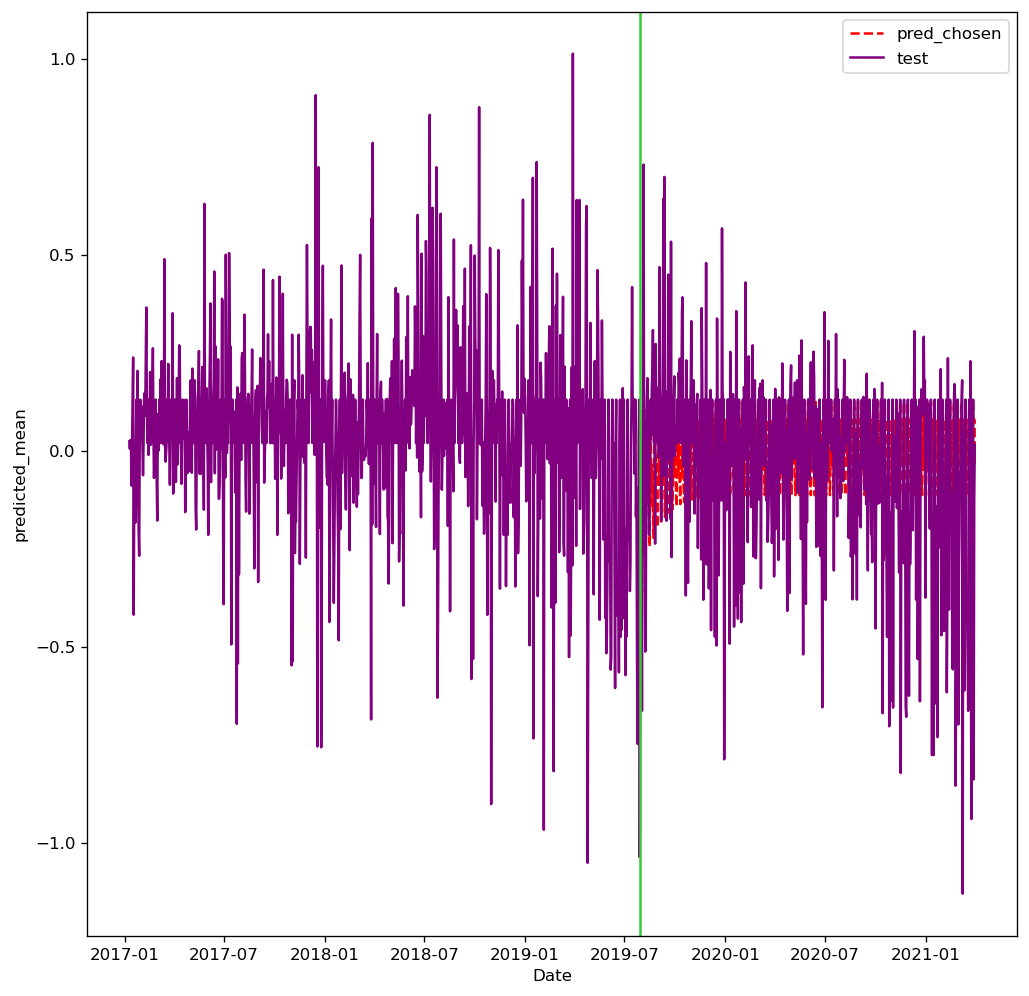

In [472]:
sns.lineplot(x=df.index[mask_after], y=predict_chosen, label='pred_chosen', linestyle='dashed', color='red')
sns.lineplot(x=df.index, y=df.Balance, label='test', color = 'purple')
plt.axvline(x=threshold_date, color='limegreen')

<Axes: xlabel='Date', ylabel='predicted_mean'>

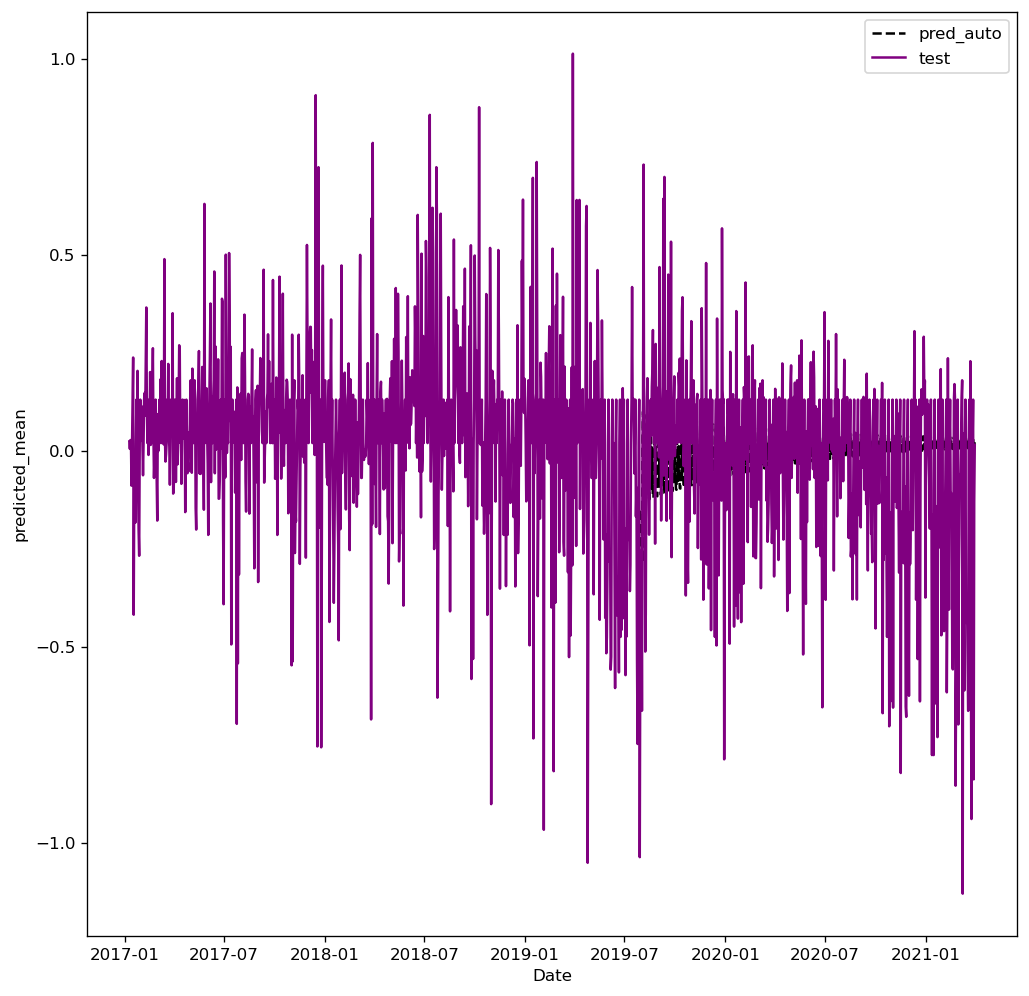

In [458]:
sns.lineplot(x=df.index[mask_after], y=predict_auto, label='pred_auto', linestyle='dashed', color='black')
sns.lineplot(x=df.index, y=df.Balance, label='test', color = 'purple')

<Axes: xlabel='Date'>

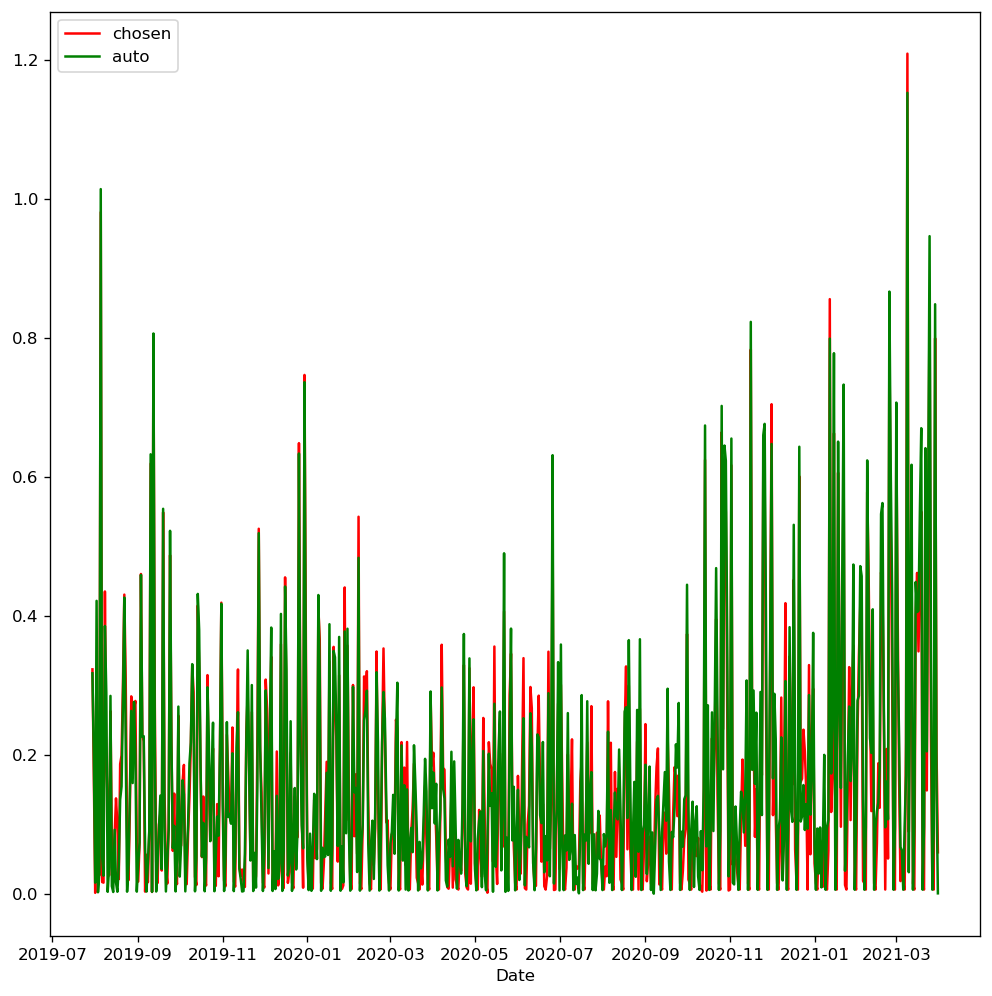

In [459]:
sns.lineplot(x=df.index[mask_after], y=(df.Balance[mask_after]-predict_chosen).abs(), label='chosen', color = 'red')
sns.lineplot(x=df.index[mask_after], y=(df.Balance[mask_after]-predict_auto).abs(), label='auto', color = 'green')

# sns.lineplot(x=df.index[mask][21:], y=df.Balance[mask][21:], label='test', color = 'purple')

Попробуем выбрать из тех, что с минимальной MAE

In [460]:
display(result_exog_table.sort_values(by=['MAE'], ascending=False).head(1))

p  d  q  P  D  Q  err_max       MAE        LLF        R2         aic
150  2  0  2  0  1  0  1.60771  0.418688 -79.110594 -3.702889  168.221188

In [461]:
model_by_MAE = ARIMA(endog=df.Balance[df.index < threshold_date], order=(2, 0, 2), seasonal_order=(0, 1, 0, 7)).fit()

In [462]:
model_by_MAE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          Balance   No. Observations:                  932
Model:             ARIMA(2, 0, 2)x(0, 1, [], 7)   Log Likelihood                 -79.111
Date:                          Fri, 05 Apr 2024   AIC                            168.221
Time:                                  01:03:12   BIC                            192.370
Sample:                              01-09-2017   HQIC                           177.434
                                   - 07-29-2019                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3202      0.021    -15.389      0.000      -0.361      -0.279
ar.L2         -0.7540      0.021    -36.449      0.000      -0.795      -0.713
ma.L1          0.4485      0.008     54.570      0.000       0.432       0.465
ma.L2          0.9919      0.008    127.875      0.000       0.977       1.007
sigma2         0.0691      0.002     29.259      0.000       0.064       0.074
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               160.47
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [463]:
predict_MAE = model_by_MAE.predict(start=threshold_date, end=end_date)

<Axes: xlabel='Date', ylabel='predicted_mean'>

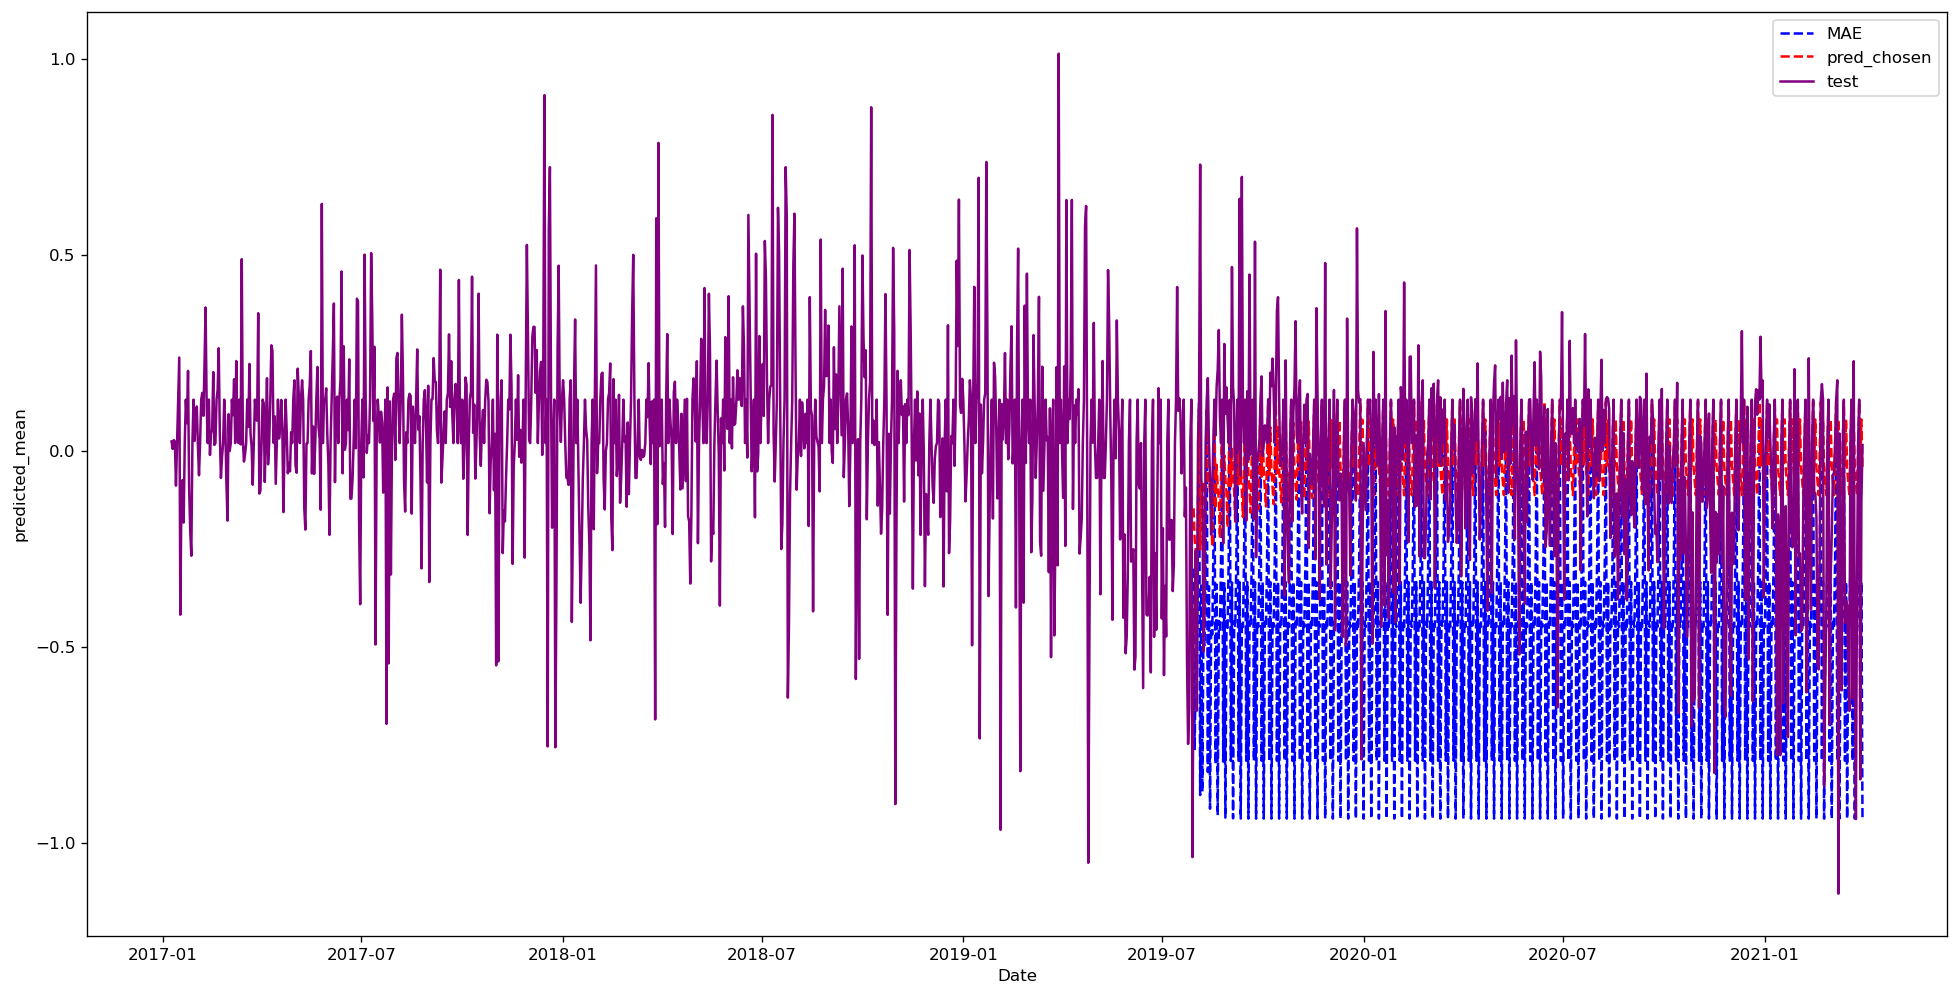

In [464]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=df.index[mask_after], y=predict_MAE, label='MAE', linestyle='dashed', color='blue', ax = ax)
sns.lineplot(x=df.index[mask_after], y=predict_chosen, label='pred_chosen', linestyle='dashed', color='red', ax=ax)

sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')

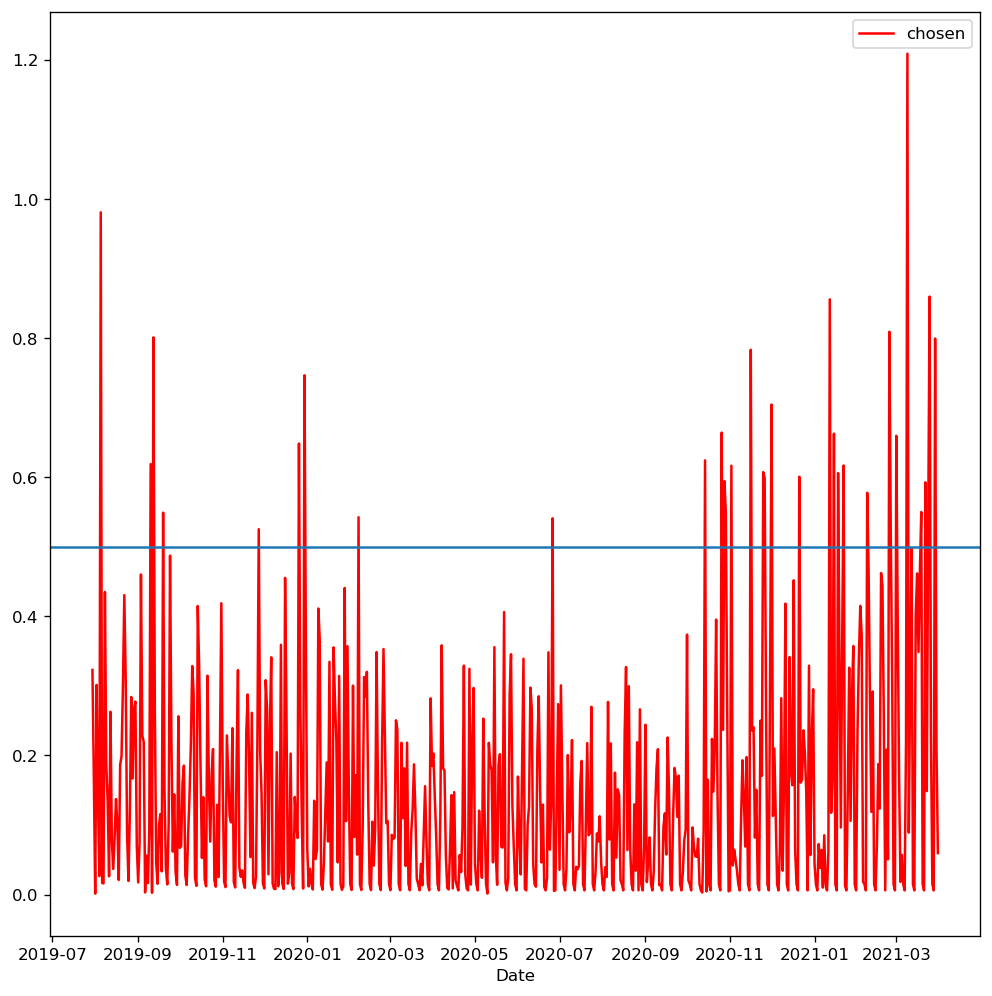

In [465]:
# sns.lineplot(x=df.index[mask_after], y=(df.Balance[mask_after]-predict_MAE).abs(), label='MAE', color = 'blue')
sns.lineplot(x=df.index[mask_after], y=(df.Balance[mask_after]-predict_chosen).abs(), label='chosen', color = 'red')
# sns.lineplot(x=df.index[mask], y=(df.Balance[mask]-predict_auto).abs(), label='auto', color = 'green')
plt.axhline(y=0.5) 

In [466]:
print(f"mean chosen = {(df.Balance[mask_after]-predict_chosen).abs().mean()}")
print(f"mean by_MAE = {(df.Balance[mask_after]-predict_MAE).abs().mean()}")
print(f"max chosen = {(df.Balance[mask_after]-predict_chosen).abs().max()}")
print(f"max by_MAE = {(df.Balance[mask_after]-predict_MAE).abs().max()}")

mean chosen = 0.1531309319034892
mean by_MAE = 0.41868805167541484
max chosen = 1.209266699066377
max by_MAE = 1.6077103416436676


### Предположим мы взяли chosen модель

**Посмотрим как ведут себя остатки**

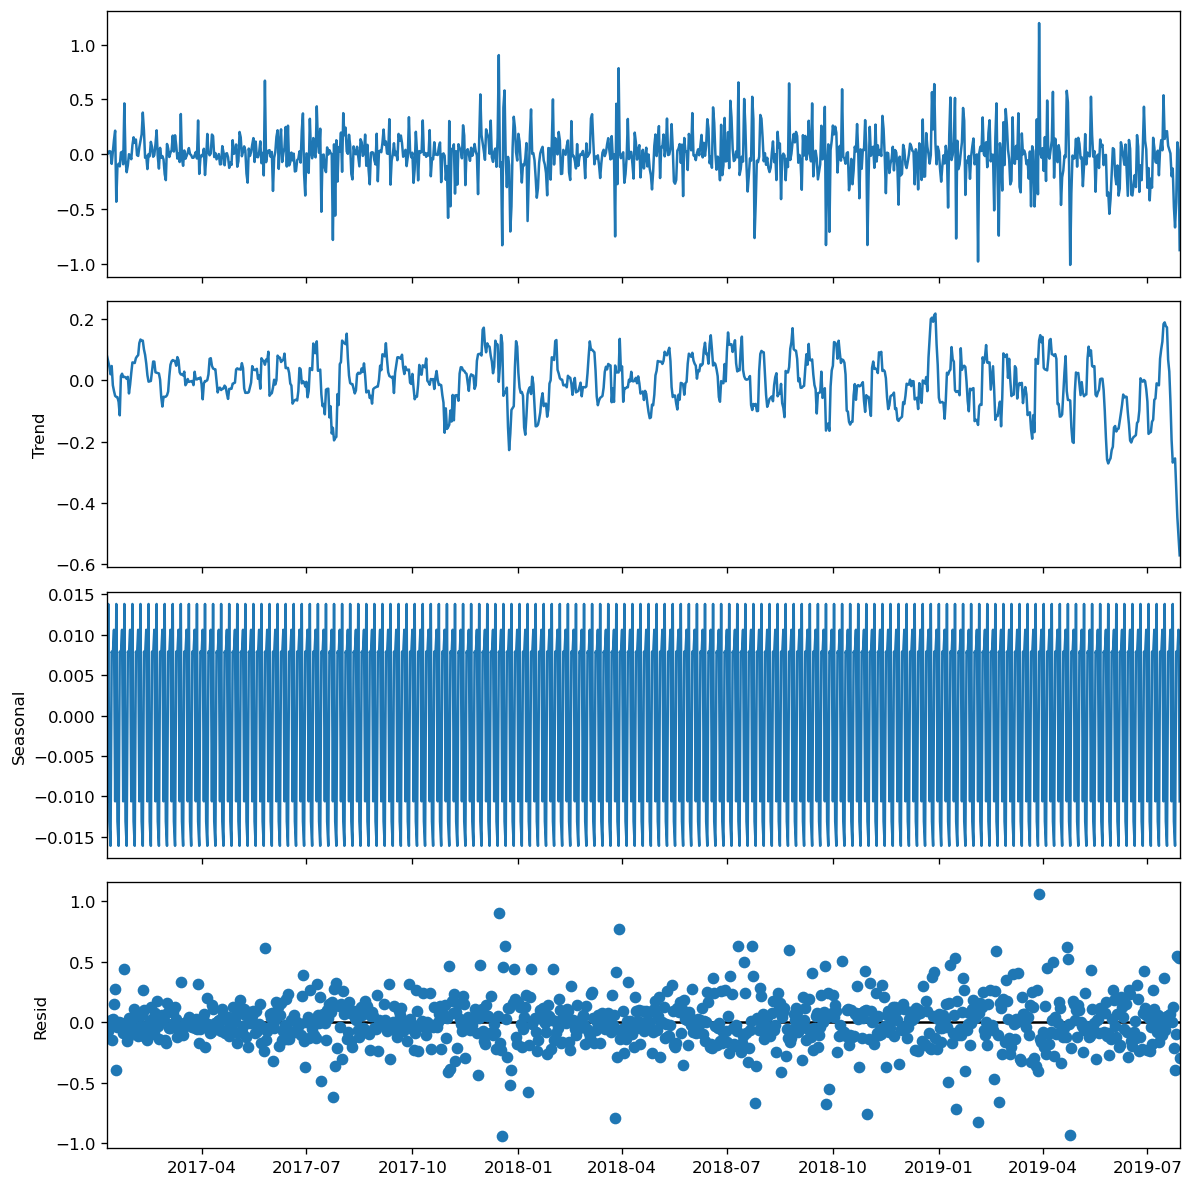

In [467]:
result_add = seasonal_decompose(best_chosen.resid, model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

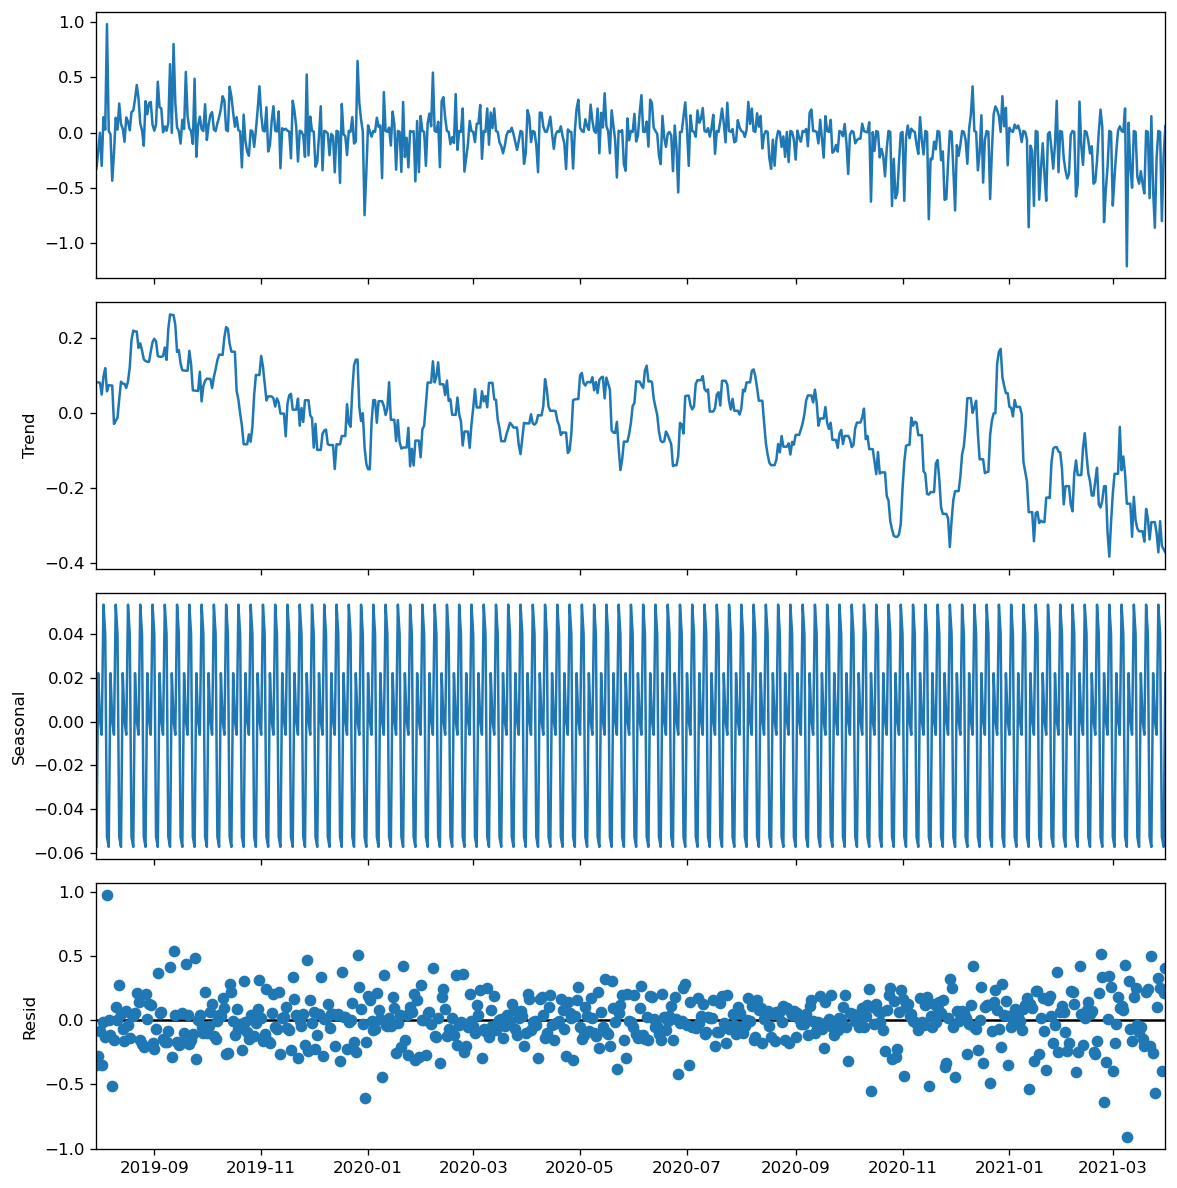

In [473]:
result_add = seasonal_decompose(df.Balance[mask_after] - predict_chosen, model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot()
plt.show()

# Попробуем зафигачить фичи дополнительные

# Курс доллара

In [530]:
print(df.index[0], df.index[-1])

2017-01-09 00:00:00 2021-03-31 00:00:00


In [531]:
USD_RUB_df = pd.read_csv(
    "/home/owner/Documents/DEV/Time_series/USD_RUB.csv",
    index_col='Дата', 
    parse_dates=['Дата'],
    usecols=['Дата', 'Цена'],
    )

In [532]:
USD_RUB_df.rename(columns={'Цена' : 'USD'}, inplace=True)

In [533]:
new_df = df.join(USD_RUB_df)
new_df

Balance  Balance_balanced  avg_Balance_by_this_month      USD
Date                                                                      
2017-01-09  0.023691          0.023691                          0  57,5159
2017-01-10  0.004693          0.004693                          0      NaN
2017-01-11  0.027189          0.027189                          0  58,2807
2017-01-12  0.023283          0.023283                          0  58,8960
2017-01-13 -0.089188         -0.089188                          0  59,6869
...              ...               ...                        ...      ...
2021-03-27  0.019422          0.019422                          0      NaN
2021-03-28  0.130265          0.130265                          0      NaN
2021-03-29 -0.838085         -0.838085                          0  75,6648
2021-03-30 -0.129422         -0.129422                          0  75,8495
2021-03-31  0.014544          0.014544                          0  75,6987

[1543 rows x 4 columns]

In [534]:
while not new_df.USD.notna().all():
    new_df.fillna(new_df.shift(1), inplace=True)

In [535]:
new_df.USD = new_df.USD.str.replace(',', '.').astype(float)

# ВВП РФ

In [536]:
GDP = {2016: 1.28, 2017: 1.57, 2018: 1.66, 2019: 1.69, 2020: 1.49, 2021: 1.84} # in trillions

new_df['last_year_GDP'] = (pd.to_datetime(new_df.index).year - 1)
new_df['last_year_GDP'] = new_df['last_year_GDP'].apply(lambda x: GDP[x])

# Ключевая ставка

In [537]:
keyRates = pd.read_csv('/home/owner/Documents/DEV/Time_series/KeyRate.csv')

# Праздничные дни

In [538]:
import holidays

In [539]:
all_holidays = pd.to_datetime(np.fromiter(holidays.RU(years=[2017, 2018, 2019, 2020, 2021]).keys(), 'datetime64[ns]'))
all_holidays

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-08', '2017-01-07',
               '2017-02-23', '2017-03-08', '2017-05-01', '2017-05-09',
               '2017-06-12', '2017-11-04', '2018-01-01', '2018-01-02',
               '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06',
               '2018-01-08', '2018-01-07', '2018-02-23', '2018-03-08',
               '2018-05-01', '2018-05-09', '2018-06-12', '2018-11-04',
               '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-08', '2019-01-07',
               '2019-02-23', '2019-03-08', '2019-05-01', '2019-05-09',
               '2019-06-12', '2019-11-04', '2020-01-01', '2020-01-02',
               '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-08', '2020-01-07', '2020-02-23', '2020-03-08',
               '2020-05-01', '2020-05-09', '2020-06-12', '2020-11-04',
      

In [540]:
new_df['holiday'] = new_df.index.isin(all_holidays).astype(int)

In [541]:
new_df.holiday.any()

True

In [542]:
bool_holiday = new_df.holiday.astype(bool)
new_df['week_before_holiday'] = bool_holiday.shift(-1).fillna(0)| \
    bool_holiday.shift(-2).fillna(0) | bool_holiday.shift(-3).fillna(0) | \
    bool_holiday.shift(-4).fillna(0) | bool_holiday.shift(-5).fillna(0) | \
    bool_holiday.shift(-6).fillna(0) | bool_holiday.shift(-7).fillna(0)
new_df.week_before_holiday = new_df.week_before_holiday.astype(int)

In [543]:
new_df['day_before_holiday'] = new_df.holiday.shift(-1).fillna(0).astype(int)

In [544]:
new_df

Balance  Balance_balanced  avg_Balance_by_this_month      USD  \
Date                                                                         
2017-01-09  0.023691          0.023691                          0  57.5159   
2017-01-10  0.004693          0.004693                          0  57.5159   
2017-01-11  0.027189          0.027189                          0  58.2807   
2017-01-12  0.023283          0.023283                          0  58.8960   
2017-01-13 -0.089188         -0.089188                          0  59.6869   
...              ...               ...                        ...      ...   
2021-03-27  0.019422          0.019422                          0  75.6633   
2021-03-28  0.130265          0.130265                          0  75.6633   
2021-03-29 -0.838085         -0.838085                          0  75.6648   
2021-03-30 -0.129422         -0.129422                          0  75.8495   
2021-03-31  0.014544          0.014544                          0  75.6987   

            last_year_GDP  holiday  week_before_holiday  day_before_holiday  
Date                                                                         
2017-01-09           1.28        0                    0                   0  
2017-01-10           1.28        0                    0                   0  
2017-01-11           1.28        0                    0                   0  
2017-01-12           1.28        0                    0                   0  
2017-01-13           1.28        0                    0                   0  
...                   ...      ...                  ...                 ...  
2021-03-27           1.49        0                    0                   0  
2021-03-28           1.49        0                    0                   0  
2021-03-29           1.49        0                    0                   0  
2021-03-30           1.49        0                    0                   0  
2021-03-31           1.49        0                    0                   0  

[1543 rows x 8 columns]

# Мб еще отдельно обработаем даты

Типо выделим месяцы и заэнкодим мб времена года

In [545]:
test = pd.to_datetime(new_df.index).month
test

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', name='Date', length=1543)

In [546]:
new_df['spring'] = pd.to_datetime(new_df.index).month.isin([3,4,5]).astype(int)
new_df['summer'] = pd.to_datetime(new_df.index).month.isin([6,7,8]).astype(int)
new_df['autumn'] = pd.to_datetime(new_df.index).month.isin([9,10,11]).astype(int)
new_df['winter'] = pd.to_datetime(new_df.index).month.isin([12,1,2]).astype(int)

Сделаем энкодинг дней недели

In [569]:
new_df['weekdays'] = new_df.index.day_name()
new_df = new_df.join(new_df['weekdays'].str.get_dummies()).drop(columns='weekdays')
for weekday in new_df.index.day_name().unique(): new_df[weekday] = new_df[weekday].astype(int)

In [549]:
new_df['month'] = new_df.index.month_name()
new_df = new_df.join(new_df['month'].str.get_dummies()).drop(columns='month')

In [550]:
new_df.columns

Index(['Balance', 'Balance_balanced', 'avg_Balance_by_this_month', 'USD',
       'last_year_GDP', 'holiday', 'week_before_holiday', 'day_before_holiday',
       'spring', 'summer', 'autumn', 'winter', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September'],
      dtype='object')

Средние значения таргета в каждом месяце

In [551]:
months = new_df.index.month_name().unique()
new_df['avg_Balance_by_this_month'] = 0
for month in months:
    mask = new_df[month].astype(bool)
    new_df[mask]['avg_Balance_by_this_month'] = new_df[mask]['Balance'].mean()

Средние значения таргета по выходным

In [552]:
mask = (new_df.Saturday | new_df.Sunday).astype(bool)
new_df[mask]['avg_Balance_weekend'] = new_df[mask]['Balance'].mean()

Средние значения по временам года

In [561]:
seasons = ['winter', 'spring', 'summer', 'autumn']
new_df['avg_Balance_by_season'] = 0
for season in seasons:
    mask = new_df[season].astype(bool)
    new_df[mask]['avg_Balance_by_season'] = new_df[mask]['Balance'].mean()

Средние значения по неделе месяца

In [573]:
new_df[mask]['avg_Balance_by_week_of_month'] = 0

mask = new_df.index.day <= 7
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask]['Balance'].mean()
mask = (new_df.index.day >= 8) & (new_df.index.day <= 14) 
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask]['Balance'].mean()
mask = (new_df.index.day >= 15) & (new_df.index.day <= 21) 
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask]['Balance'].mean()
mask = new_df.index.day >= 22
new_df[mask]['avg_Balance_by_week_of_month'] = new_df[mask]['Balance'].mean()

Пусть будет признак четности года

In [581]:
new_df['even_year'] = (~(new_df.index.year % 2).astype(bool)).astype(int)

Средние по дням недели

In [571]:
new_df['avg_Balance_by_day'] = 0
for week_day in new_df.index.day_name():
    mask = new_df[week_day].astype(bool)
    new_df[mask]['avg_Balance_by_season'] = new_df[mask]['Balance'].mean()

Средняя по кварталам

In [574]:
new_df[mask]['avg_Balance_by_quartal'] = 0

mask = new_df.index.month.isin([1,2,3])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask]['Balance'].mean()
mask = new_df.index.month.isin([4,5,6])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask]['Balance'].mean()
mask = new_df.index.month.isin([7,8,9])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask]['Balance'].mean()
mask = new_df.index.month.isin([10,11,12])
new_df[mask]['avg_Balance_by_quartal'] = new_df[mask]['Balance'].mean()

# Налоговые дни

Для ЕНС установлены единые сроки: до 25 числа месяца, следующего за отчетным периодом, нужно отчитаться перед налоговой, а до 28 числа — уплатить налоги.

In [554]:
new_df['tax_day'] = pd.to_datetime(new_df.index).day.isin([28]).astype(int)

# Сдвиги

# new_df

In [582]:
new_df

Balance  Balance_balanced  avg_Balance_by_this_month      USD  \
Date                                                                         
2017-01-16  0.237591          0.237591                          0  59.8588   
2017-01-17 -0.418254         -0.418254                          0  59.4025   
2017-01-18 -0.105379         -0.105379                          0  59.5544   
2017-01-19 -0.074857         -0.074857                          0  59.7304   
2017-01-20 -0.183367         -0.183367                          0  59.7521   
...              ...               ...                        ...      ...   
2021-03-27  0.019422          0.019422                          0  75.6633   
2021-03-28  0.130265          0.130265                          0  75.6633   
2021-03-29 -0.838085         -0.838085                          0  75.6648   
2021-03-30 -0.129422         -0.129422                          0  75.8495   
2021-03-31  0.014544          0.014544                          0  75.6987   

            last_year_GDP  holiday  week_before_holiday  day_before_holiday  \
Date                                                                          
2017-01-16           1.28        0                    0                   0   
2017-01-17           1.28        0                    0                   0   
2017-01-18           1.28        0                    0                   0   
2017-01-19           1.28        0                    0                   0   
2017-01-20           1.28        0                    0                   0   
...                   ...      ...                  ...                 ...   
2021-03-27           1.49        0                    0                   0   
2021-03-28           1.49        0                    0                   0   
2021-03-29           1.49        0                    0                   0   
2021-03-30           1.49        0                    0                   0   
2021-03-31           1.49        0                    0                   0   

            spring  summer  ...  even_year   weekdays  avg_Balance_by_day  \
Date                        ...                                             
2017-01-16       0       0  ...          0     Monday                   0   
2017-01-17       0       0  ...          0    Tuesday                   0   
2017-01-18       0       0  ...          0  Wednesday                   0   
2017-01-19       0       0  ...          0   Thursday                   0   
2017-01-20       0       0  ...          0     Friday                   0   
...            ...     ...  ...        ...        ...                 ...   
2021-03-27       1       0  ...          0   Saturday                   0   
2021-03-28       1       0  ...          0     Sunday                   0   
2021-03-29       1       0  ...          0     Monday                   0   
2021-03-30       1       0  ...          0    Tuesday                   0   
2021-03-31       1       0  ...          0  Wednesday                   0   

              shift1    shift2    shift3    shift4    shift5    shift6  \
Date                                                                     
2017-01-16  0.130265  0.019422 -0.089188  0.023283  0.027189  0.004693   
2017-01-17  0.237591  0.130265  0.019422 -0.089188  0.023283  0.027189   
2017-01-18 -0.418254  0.237591  0.130265  0.019422 -0.089188  0.023283   
2017-01-19 -0.105379 -0.418254  0.237591  0.130265  0.019422 -0.089188   
2017-01-20 -0.074857 -0.105379 -0.418254  0.237591  0.130265  0.019422   
...              ...       ...       ...       ...       ...       ...   
2021-03-27 -0.339415 -0.939277 -0.568356  0.228305 -0.631290  0.130265   
2021-03-28  0.019422 -0.339415 -0.939277 -0.568356  0.228305 -0.631290   
2021-03-29  0.130265  0.019422 -0.339415 -0.939277 -0.568356  0.228305   
2021-03-30 -0.838085  0.130265  0.019422 -0.339415 -0.939277 -0.568356   
2021-03-31 -0.129422 -0.838085  0.130265  0.019422 -0.339415 -0.939277   

     

# Пытаемся замутить SARIMAX

In [556]:
best_chosen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           Balance   No. Observations:                  932
Model:             ARIMA(3, 0, 3)x(3, 1, [1], 7)   Log Likelihood                  88.493
Date:                           Fri, 05 Apr 2024   AIC                           -154.986
Time:                                   05:39:02   BIC                           -101.858
Sample:                               01-09-2017   HQIC                          -134.718
                                    - 07-29-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5096      0.038     13.377      0.000       0.435       0.584
ar.L2         -0.4892      0.033    -14.730      0.000      -0.554      -0.424
ar.L3          0.9083      0.041     22.073      0.000       0.828       0.989
ma.L1         -0.4246      0.045     -9.462      0.000      -0.513      -0.337
ma.L2          0.4829      0.030     15.976      0.000       0.424       0.542
ma.L3         -0.8994      0.046    -19.684      0.000      -0.989      -0.810
ar.S.L7        0.1758      0.032      5.468      0.000       0.113       0.239
ar.S.L14      -0.0720      0.028     -2.592      0.010      -0.126      -0.018
ar.S.L21       0.0600      0.033      1.817      0.069      -0.005       0.125
ma.S.L7       -0.9774      0.018    -55.067      0.000      -1.012      -0.943
sigma2         0.0476      0.001     34.578      0.000       0.045       0.050
===================================================================================
Ljung-Box (L1) (Q):                   2.77   Jarque-Bera (JB):               605.63
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               2.89   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [557]:
new_df.columns

Index(['Balance', 'Balance_balanced', 'avg_Balance_by_this_month', 'USD',
       'last_year_GDP', 'holiday', 'week_before_holiday', 'day_before_holiday',
       'spring', 'summer', 'autumn', 'winter', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September', 'avg_Balance_by_season', 'tax_day'],
      dtype='object')

In [558]:
new_df_train = new_df[new_df.index < threshold_date]
new_df_test = new_df[(new_df.index >= threshold_date) & (new_df.index <= end_date)]
exog = set(new_df_train.columns) - {'Balance'}

In [559]:

ps = range(0, 3)
d = 0
qs = range(0, 3)
Ps = [5,6,7, 11, 12]
Ds = range(0, 3)
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
print(parameters_list)
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for p, q, P, D, Q in tqdm(parameters_list):
    try:
        model_SARIMAX = ARIMA(endog=new_df_train.Balance, exog=new_df_train[exog], order=(p, d, q), seasonal_order=(P, D, Q, 7))
        model_SARIMAX = model_SARIMAX.fit()
    except ValueError:
        print('wrong parameters:', (p,d,q,P,D,Q))
        continue
    mask = (new_df.index >= threshold_date) & (new_df.index <= end_date)
    predict=model_SARIMAX.predict(start=threshold_date, end=end_date, exog=new_df_test[exog])
    err_max = (new_df.Balance[mask]-predict).abs().max()
    err_mean = (new_df.Balance[mask]-predict).abs().mean()
    llf = model_SARIMAX.llf
    r2 = r2_score(new_df.Balance[mask], predict)
    aic = model_SARIMAX.aic
    if aic < best_aic:
        best_chosen = model_SARIMAX
        best_err_max = err_max
        best_err_mean = err_mean
        best_llf = llf
        best_r2 = r2
        best_combination = (p,d,q,P,D,Q)
        best_aic = aic
    results.append([p, d, q, P, D, Q, err_max, err_mean, llf, r2, aic])

[(0, 0, 5, 0, 0), (0, 0, 5, 0, 1), (0, 0, 5, 0, 2), (0, 0, 5, 1, 0), (0, 0, 5, 1, 1), (0, 0, 5, 1, 2), (0, 0, 5, 2, 0), (0, 0, 5, 2, 1), (0, 0, 5, 2, 2), (0, 0, 6, 0, 0), (0, 0, 6, 0, 1), (0, 0, 6, 0, 2), (0, 0, 6, 1, 0), (0, 0, 6, 1, 1), (0, 0, 6, 1, 2), (0, 0, 6, 2, 0), (0, 0, 6, 2, 1), (0, 0, 6, 2, 2), (0, 0, 7, 0, 0), (0, 0, 7, 0, 1), (0, 0, 7, 0, 2), (0, 0, 7, 1, 0), (0, 0, 7, 1, 1), (0, 0, 7, 1, 2), (0, 0, 7, 2, 0), (0, 0, 7, 2, 1), (0, 0, 7, 2, 2), (0, 0, 11, 0, 0), (0, 0, 11, 0, 1), (0, 0, 11, 0, 2), (0, 0, 11, 1, 0), (0, 0, 11, 1, 1), (0, 0, 11, 1, 2), (0, 0, 11, 2, 0), (0, 0, 11, 2, 1), (0, 0, 11, 2, 2), (0, 0, 12, 0, 0), (0, 0, 12, 0, 1), (0, 0, 12, 0, 2), (0, 0, 12, 1, 0), (0, 0, 12, 1, 1), (0, 0, 12, 1, 2), (0, 0, 12, 2, 0), (0, 0, 12, 2, 1), (0, 0, 12, 2, 2), (0, 1, 5, 0, 0), (0, 1, 5, 0, 1), (0, 1, 5, 0, 2), (0, 1, 5, 1, 0), (0, 1, 5, 1, 1), (0, 1, 5, 1, 2), (0, 1, 5, 2, 0), (0, 1, 5, 2, 1), (0, 1, 5, 2, 2), (0, 1, 6, 0, 0), (0, 1, 6, 0, 1), (0, 1, 6, 0, 2), (0, 1, 6, 1,

  0%|          | 0/405 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
result_exog_table = pd.DataFrame(results)
result_exog_table.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'err_max', 'err_mean', 'LLF', 'R2', 'aic']
display(result_exog_table.sort_values(by=['LLF'], ascending=False).head(2))
display(result_exog_table.sort_values(by='err_max', ascending=True).head(2))
display(result_exog_table.sort_values(by=['aic'], ascending=True).head(2))

p  d  q   P  D  Q   err_max  err_mean          LLF        R2          aic
261  1  0  2  12  0  0  0.013306  0.002945  3964.969881  0.999789 -7857.939762
252  1  0  2  11  0  0  0.013307  0.002944  3964.820176  0.999789 -7859.640351

p  d  q   P  D  Q   err_max  err_mean          LLF        R2          aic
37   0  0  0  12  0  1  0.013303  0.002943  3964.022855  0.999789 -7860.045711
262  1  0  2  12  0  1  0.013305  0.002944  3964.623133  0.999789 -7855.246267

p  d  q  P  D  Q   err_max  err_mean          LLF        R2          aic
18  0  0  0  7  0  0  0.013308  0.002944  3962.206572  0.999789 -7868.413144
0   0  0  0  5  0  0  0.013310  0.002945  3960.022583  0.999789 -7868.045165

In [ ]:
mask = (df.index >= threshold_date) & (df.index <= end_date)
predict_SARIMAX = best_chosen.predict(start=threshold_date, end=end_date, exog=new_df[mask][exog])
print(len(predict_SARIMAX), len(df.index[mask]))

611 611


In [ ]:
best_chosen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Balance   No. Observations:                  932
Model:              ARIMA(7, 0, 0, 7)   Log Likelihood                3962.207
Date:                Thu, 04 Apr 2024   AIC                          -7868.413
Time:                        16:15:27   BIC                          -7732.968
Sample:                    01-09-2017   HQIC                         -7816.759
                         - 07-29-2019                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0016      0.001     -1.105      0.269      -0.004       0.001
winter                 -0.0005      0.000     -1.275      0.202      -0.001       0.000
USD                  3.712e-05   4.79e-05      0.774      0.439   -5.68e-05       0.000
autumn                 -0.0006      0.000     -1.290      0.197      -0.001       0.000
Saturday               -0.0007      0.002     -0.439      0.661      -0.004       0.002
summer                 -0.0002      0.000     -0.453      0.651      -0.001       0.001
Income                  0.9987      0.000   2563.074      0.000       0.998       1.000
tax_day                 0.0004      0.001      0.588      0.557      -0.001       0.002
easter                 -0.0003      0.000     -0.838      0.402      -0.001       0.000
Tuesday                 0.0002      0.001      0.419      0.675      -0.001       0.001
Monday                 -0.0002      0.001     -0.289      0.772      -0.001       0.001
week_before_holiday -6.968e-05      0.000     -0.185      0.853      -0.001       0.001
Outcome                -0.9991      0.000  -3487.520      0.000      -1.000      -0.999
Friday                 -0.0003      0.001     -0.616      0.538      -0.001       0.001
day_before_holiday      0.0004      0.001      0.453      0.651      -0.001       0.002
last_year_GDP           0.0003      0.001      0.240      0.810      -0.002       0.003
holiday                -0.0007      0.003     -0.224      0.823      -0.006       0.005
Thursday             6.938e-05      0.001      0.126      0.900      -0.001       0.001
Wednesday           -2.814e-05      0.001     -0.051      0.960      -0.001       0.001
Sunday                 -0.0007      0.003     -0.247      0.805      -0.006       0.005
ar.S.L7                -0.0699      0.031     -2.282      0.022      -0.130      -0.010
ar.S.L14                0.0195      0.034      0.575      0.565      -0.047       0.086
ar.S.L21                0.0112      0.033      0.344      0.731      -0.053       0.075
ar.S.L28                0.0469      0.029      1.639      0.101      -0.009       0.103
ar.S.L35               -0.0640      0.031     -2.039      0.041      -0.125      -0.002
ar.S.L42               -0.0461      0.030     -1.518      0.129      -0.106       0.013
ar.S.L49               -0.0599      0.031     -1.958      0.050      -0.120    5.24e-05
sigma2               1.221e-05   4.29e-07     28.462      0.000    1.14e-05    1.31e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               185.66
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings

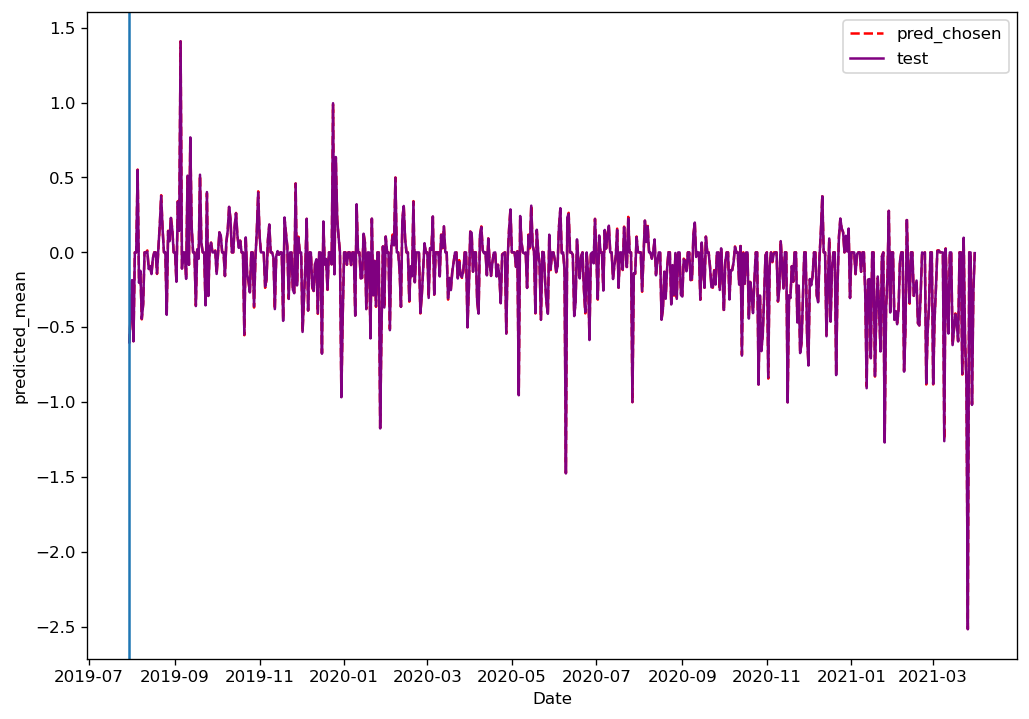

In [ ]:
sns.lineplot(x=df.index[mask], y=predict_SARIMAX, label='pred_chosen', linestyle='dashed', color='red')
sns.lineplot(x=df.index[mask], y=df.Balance[mask], label='test', color = 'purple')
plt.axvline(x=threshold_date)

# Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier

In [ ]:
modelSK = GradientBoostingRegressor()
modelSK.fit(X, y)
modelXGB = XGBRegressor(objective='reg:squarederror')
modelXGB.fit(X, y)
modelLGBM = LGBMRegressor()
modelLGBM.fit(X, y)